In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from PIL import Image
from time import time
import math

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [7]:
#!unzip -u "/content/drive/MyDrive/sisi/out_bw_images.zip" -d "/content/drive/MyDrive/sisi"

In [8]:
data_dir_bw = "/content/drive/MyDrive/sisi/out_bw_images"
data_dir_col = "/content/drive/MyDrive/sisi/out_color_images"

In [9]:
assert len(os.listdir(data_dir_col)) == 11640
assert len(os.listdir(data_dir_bw)) == 11640

In [10]:
SIZE = 100 # 100x100 dimensions

In [11]:
def load_images(data_dir, force_rgb=False):
    images = []
    labels = []
    total = len(os.listdir(data_dir))
    for i, image_name in enumerate(os.listdir(data_dir)):
        if (i % (total//5) == 0):
            print(f'INFO: Loading image {i+1}/{total}')
        path = os.path.join(data_dir, image_name)
        im = Image.open(path)
        if force_rgb:
            im = im.convert('RGB')
        images.append(np.asarray(im))
        labels.append(image_name.split("-")[1].rsplit(".", 1)[0])

    # Map characters to integers
    labels_mapping = {i: l for i, l in enumerate(sorted(set(labels)))}
    labels_mapping_rev = {l: i for i, l in labels_mapping.items()}

    labels = [labels_mapping_rev[l] for l in labels]

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, labels_mapping

In [12]:
def plot_data(images, labels, labels_mapping, cmap=None, size_y=5, size_x=5):
    plt.figure(figsize=(10,10))
    for i, image in enumerate(images[: size_x * size_y]):
        plt.subplot(size_x, size_y,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=cmap)
        plt.xlabel(labels_mapping[labels[i]])
    plt.show()

In [13]:
data_col = load_images(data_dir_col)
data_bw = load_images(data_dir_bw)
data_bw_3_channels = load_images(data_dir_bw, force_rgb=True)  # for transfer learning

INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640
INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640
INFO: Loading image 1/11640
INFO: Loading image 2329/11640
INFO: Loading image 4657/11640
INFO: Loading image 6985/11640
INFO: Loading image 9313/11640


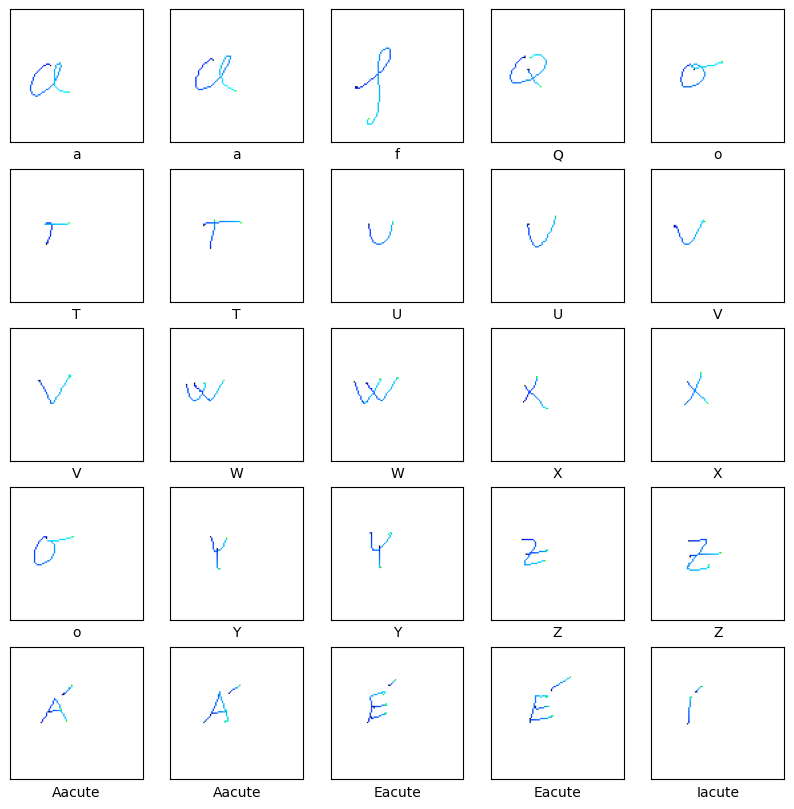

In [ ]:
plot_data(*data_col)

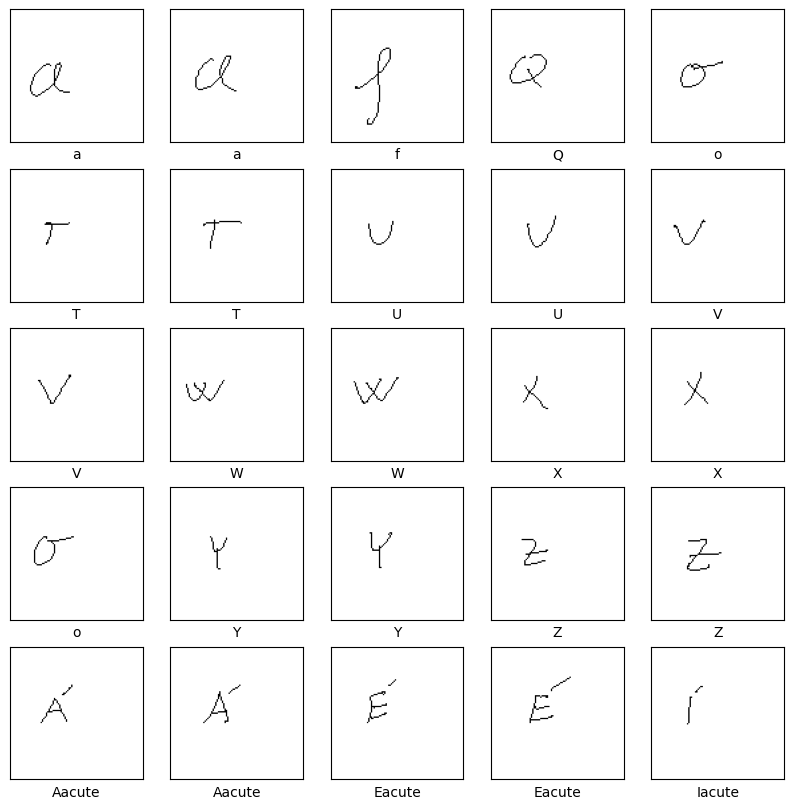

In [ ]:
plot_data(*data_bw, cmap='gray')

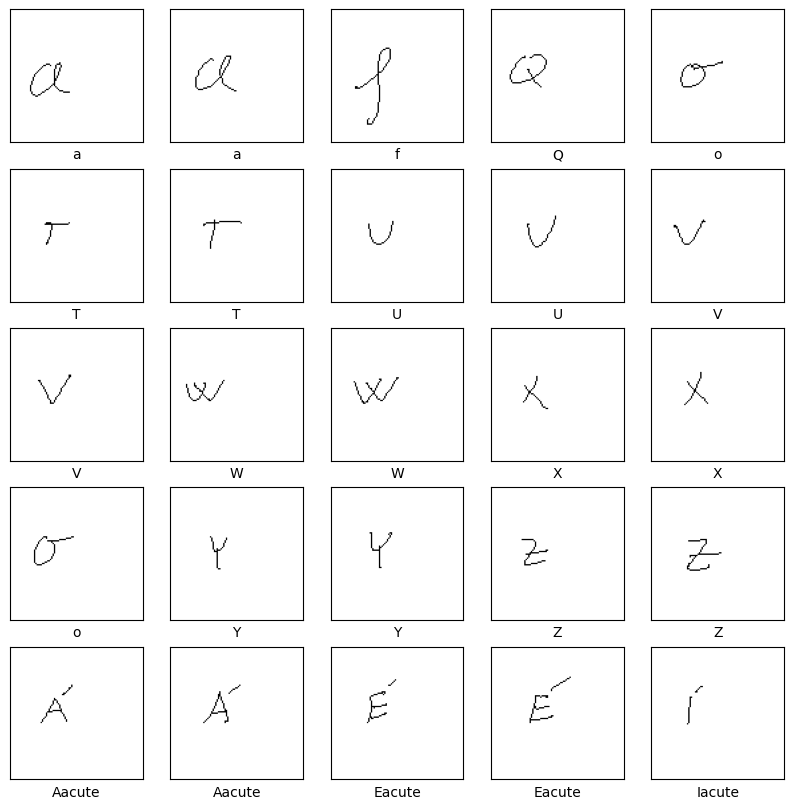

In [ ]:
plot_data(*data_bw_3_channels)

In [14]:
class PreparedData:
    def __init__(self, train_images, train_labels, test_images, test_labels, labels_len):
        self.train_images = np.array(train_images)
        self.train_labels = np.array(train_labels)
        self.test_images= np.array(test_images)
        self.test_labels = np.array(test_labels)
        self.labels_len = labels_len
        train_labels_oh = tf.one_hot(self.train_labels, labels_len)
        self.train_labels_oh = train_labels_oh.reshape(train_labels_oh.shape[0], labels_len)
        test_labels_oh = tf.one_hot(self.test_labels, labels_len)
        self.test_labels_oh = test_labels_oh.reshape(test_labels_oh.shape[0], labels_len)

In [15]:
def prepare_data(images, labels, labels_mapping, idx=100):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    for l in labels_mapping.keys():
        label_images = images[labels == l]
        train_images.extend(label_images[:idx])
        train_labels.extend([l]*idx)
        test_images.extend(label_images[idx:])
        test_labels.extend([l]*(len(label_images) - idx))
    return PreparedData(train_images, train_labels, test_images, test_labels, len(labels_mapping))

In [16]:
d_col = prepare_data(*data_col)
d_bw = prepare_data(*data_bw)
d_bw_3= prepare_data(*data_bw_3_channels)

In [ ]:
# d_col.train_images.shape, d_col.train_labels.shape, d_col.test_images.shape, d_col.test_labels.shape

In [30]:
def plot_subplot(hist_bw, hist_col, title, metric):
    epochs = [i for i in range(1, len(hist_bw['loss']) + 1)]
    plt.xlim([1, len(epochs)])
    plt.ylim([0, 0.05 if metric == 'loss' else 1])
    plt.xlabel("Numer epoki")
    polish_name = 'F. kosztu ' if metric == 'loss' else 'Dokładność '
    plt.ylabel("Wartość " + ("funkcji kosztu" if metric == "loss" else "dokładności"))
    plt.plot(epochs, hist_bw[metric], label=polish_name + "dla zb. treningowego - czarno-białe obrazy", c='purple')
    plt.plot(epochs, hist_bw['val_' + metric], label=polish_name + "dla zb. walidacyjnego - czarno-białe obrazy", c='violet')
    plt.plot(epochs, hist_col[metric], label=polish_name + "dla zb.treningowego - kolorowe obrazy", c='navy')
    plt.plot(epochs, hist_col['val_' + metric], label=polish_name + "dla zb. treningowego - kolorowe obrazy", c='royalblue')
    plt.title(title + " - " + ("Funkcja kosztu" if metric == 'loss' else "Dokładność"))
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, -0.15))

def plot_params(hist_bw, hist_col, title):
    plt.figure(figsize=(10, 10), dpi=100)

    plt.subplot(2, 1, 1)
    plot_subplot(hist_bw, hist_col, title, 'accuracy')
    
    plt.subplot(2, 1, 2)
    plot_subplot(hist_bw, hist_col, title, 'loss')

    plt.subplots_adjust(hspace=0.6)
    plt.show()

In [18]:
def run_model(model, data, epochs=150):
    start_time = time()
    hist = model.fit(data.train_images, data.train_labels_oh, batch_size=64, epochs=epochs, validation_data=(data.test_images, data.test_labels_oh))
    elapsed_time = time() - start_time
    print("Elapsed time [s]:", elapsed_time)
    return hist.history

In [19]:
def add_conv_block(model, filters, activation=tf.keras.activations.sigmoid, dropout=0):
    model.add(tf.keras.layers.Conv2D(filters, (3, 3), padding='SAME', activation=activation))
    model.add(tf.keras.layers.Conv2D(filters, (3, 3), padding='SAME', activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='SAME'))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

In [20]:
# backup if we wish to change charts

def dump_res(res_bw, res_c):
    for h in [res_bw, res_c]:
        print(max(h['val_accuracy']), h['val_accuracy'])
        print(max(h['accuracy']), h['accuracy'])
        print(min(h['val_loss']), h['val_loss'])
        print(min(h['loss']), h['loss'])

# Eksperymenty


In [ ]:
def get_basic_model(labels_len, channels_num=3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100, 100, channels_num)))
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    add_conv_block(model, 20, activation=tf.keras.activations.relu, dropout=0.1)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 40, activation=tf.keras.activations.relu, dropout=0.2)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 80, activation=tf.keras.activations.relu, dropout=0.3)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 160, activation=tf.keras.activations.relu, dropout=0.4)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(labels_len, activation=tf.keras.activations.softmax))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
res_c = run_model(get_basic_model(d_col.labels_len), d_col)
res_bw = run_model(get_basic_model(d_bw.labels_len, 1), d_bw)

Epoch 1/150
152/152 [==============================] - 12s 64ms/step - loss: 5.4192 - accuracy: 0.0122 - val_loss: 4.8035 - val_accuracy: 0.0103
Epoch 2/150
152/152 [==============================] - 9s 61ms/step - loss: 4.3218 - accuracy: 0.0748 - val_loss: 6.7789 - val_accuracy: 0.0103
Epoch 3/150
152/152 [==============================] - 9s 59ms/step - loss: 3.4691 - accuracy: 0.1600 - val_loss: 6.6318 - val_accuracy: 0.0103
Epoch 4/150
152/152 [==============================] - 9s 61ms/step - loss: 2.7561 - accuracy: 0.2788 - val_loss: 3.7880 - val_accuracy: 0.0907
Epoch 5/150
152/152 [==============================] - 9s 59ms/step - loss: 2.1723 - accuracy: 0.4016 - val_loss: 2.4043 - val_accuracy: 0.3577
Epoch 6/150
152/152 [==============================] - 9s 59ms/step - loss: 1.7084 - accuracy: 0.5192 - val_loss: 1.4109 - val_accuracy: 0.6021
Epoch 7/150
152/152 [==============================] - 9s 59ms/step - loss: 1.3890 - accuracy: 0.6038 - val_loss: 1.2030 - val_accuracy

In [ ]:
dump_res(res_bw, res_c)

0.8695876002311707 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.19381442666053772, 0.446391761302948, 0.5654639005661011, 0.6628866195678711, 0.6649484634399414, 0.7489690780639648, 0.7448453903198242, 0.7690721750259399, 0.7819587588310242, 0.7896907329559326, 0.777319610118866, 0.803608238697052, 0.7412371039390564, 0.8113402128219604, 0.8056700825691223, 0.8283505439758301, 0.8355669975280762, 0.8123711347579956, 0.8226804137229919, 0.8324742317199707, 0.8396907448768616, 0.8386598229408264, 0.8273195624351501, 0.8412371277809143, 0.8355669975280762, 0.839175283908844, 0.7855669856071472, 0.8226804137229919, 0.8407216668128967, 0.8443298935890198, 0.8474226593971252, 0.8510309457778931, 0.8546391725540161, 0.8525773286819458, 0.8494845628738403, 0.857216477394104, 0.8489691019058228, 0.8489691019058228, 0.8556700944900513, 0.8628866076469421, 0.8515464067459106, 0.8561855554580688, 0.8623711466789246, 0.8500000238418579, 0.8365979194641113, 0.8515464067459106

In [ ]:
#0.8695876002311707 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.19381442666053772, 0.446391761302948, 0.5654639005661011, 0.6628866195678711, 0.6649484634399414, 0.7489690780639648, 0.7448453903198242, 0.7690721750259399, 0.7819587588310242, 0.7896907329559326, 0.777319610118866, 0.803608238697052, 0.7412371039390564, 0.8113402128219604, 0.8056700825691223, 0.8283505439758301, 0.8355669975280762, 0.8123711347579956, 0.8226804137229919, 0.8324742317199707, 0.8396907448768616, 0.8386598229408264, 0.8273195624351501, 0.8412371277809143, 0.8355669975280762, 0.839175283908844, 0.7855669856071472, 0.8226804137229919, 0.8407216668128967, 0.8443298935890198, 0.8474226593971252, 0.8510309457778931, 0.8546391725540161, 0.8525773286819458, 0.8494845628738403, 0.857216477394104, 0.8489691019058228, 0.8489691019058228, 0.8556700944900513, 0.8628866076469421, 0.8515464067459106, 0.8561855554580688, 0.8623711466789246, 0.8500000238418579, 0.8365979194641113, 0.8515464067459106, 0.8520618677139282, 0.8479381203651428, 0.8510309457778931, 0.8479381203651428, 0.857216477394104, 0.8520618677139282, 0.8561855554580688, 0.8500000238418579, 0.8484535813331604, 0.857216477394104, 0.8484535813331604, 0.8530927896499634, 0.8546391725540161, 0.861855685710907, 0.8603093028068542, 0.8530927896499634, 0.8546391725540161, 0.8587628602981567, 0.8597938418388367, 0.853608250617981, 0.8525773286819458, 0.853608250617981, 0.857216477394104, 0.8649484515190125, 0.8587628602981567, 0.8510309457778931, 0.8582473993301392, 0.8546391725540161, 0.8582473993301392, 0.853608250617981, 0.8577319383621216, 0.8546391725540161, 0.8541237115859985, 0.8628866076469421, 0.8510309457778931, 0.8561855554580688, 0.8211340308189392, 0.8515464067459106, 0.8592783212661743, 0.8484535813331604, 0.8525773286819458, 0.8623711466789246, 0.8582473993301392, 0.8649484515190125, 0.8567010164260864, 0.861855685710907, 0.8603093028068542, 0.8695876002311707, 0.8634020686149597, 0.8567010164260864, 0.8561855554580688, 0.8587628602981567, 0.8597938418388367, 0.8597938418388367, 0.8556700944900513, 0.8556700944900513, 0.8608247637748718, 0.8603093028068542, 0.8577319383621216, 0.8556700944900513, 0.861855685710907, 0.8541237115859985, 0.8597938418388367, 0.8551546335220337, 0.861855685710907, 0.8587628602981567, 0.8582473993301392, 0.8634020686149597, 0.8639175295829773, 0.8623711466789246, 0.8567010164260864, 0.8525773286819458, 0.8582473993301392, 0.8577319383621216, 0.8623711466789246, 0.8541237115859985, 0.8597938418388367, 0.8603093028068542, 0.8628866076469421, 0.8587628602981567, 0.8623711466789246, 0.8659793734550476, 0.8561855554580688, 0.861855685710907, 0.8664948344230652, 0.8510309457778931, 0.8587628602981567, 0.8623711466789246, 0.8613402247428894, 0.8623711466789246, 0.8623711466789246, 0.8603093028068542, 0.8634020686149597, 0.8628866076469421, 0.8639175295829773, 0.8634020686149597, 0.8608247637748718, 0.8567010164260864, 0.8608247637748718, 0.8597938418388367, 0.8603093028068542]
#0.9851546287536621 [0.028247423470020294, 0.11649484187364578, 0.2002061903476715, 0.29216495156288147, 0.3971134126186371, 0.49814432859420776, 0.5736082196235657, 0.626494824886322, 0.6812371015548706, 0.7071133852005005, 0.7360824942588806, 0.757422685623169, 0.7782474160194397, 0.7943298816680908, 0.812474250793457, 0.8175257444381714, 0.8323711156845093, 0.8438144326210022, 0.8486598134040833, 0.8541237115859985, 0.864639163017273, 0.8643298745155334, 0.8692783713340759, 0.8806185722351074, 0.8819587826728821, 0.8873195648193359, 0.8947422504425049, 0.8931958675384521, 0.9010308980941772, 0.9030928015708923, 0.903195858001709, 0.9059793949127197, 0.9089690446853638, 0.9142268300056458, 0.9097937941551208, 0.9137113690376282, 0.92030930519104, 0.9228866100311279, 0.9241237044334412, 0.92711341381073, 0.9277319312095642, 0.9278350472450256, 0.9284536242485046, 0.9322680234909058, 0.9364948272705078, 0.9376288652420044, 0.9367010593414307, 0.9399999976158142, 0.9379381537437439, 0.9431958794593811, 0.9402061700820923, 0.9405154585838318, 0.9432989954948425, 0.9413402080535889, 0.9465979337692261, 0.9432989954948425, 0.9465979337692261, 0.9487628936767578, 0.9490721821784973, 0.9483504891395569, 0.9520618319511414, 0.9486597776412964, 0.95061856508255, 0.947010338306427, 0.9515463709831238, 0.9545360803604126, 0.9564948678016663, 0.9532989859580994, 0.9575257897377014, 0.9559794068336487, 0.9579381346702576, 0.9579381346702576, 0.9595876336097717, 0.9590721726417542, 0.9606185555458069, 0.9606185555458069, 0.9623711109161377, 0.9596907496452332, 0.961649477481842, 0.9613401889801025, 0.962061882019043, 0.9621649384498596, 0.9631958603858948, 0.9663917422294617, 0.9665979146957397, 0.9663917422294617, 0.9672164916992188, 0.968453586101532, 0.9644330143928528, 0.9658762812614441, 0.9693814516067505, 0.9688659906387329, 0.9674226641654968, 0.9721649289131165, 0.9672164916992188, 0.9713401794433594, 0.9682474136352539, 0.9712371230125427, 0.9687628746032715, 0.9712371230125427, 0.9727835059165955, 0.9741237163543701, 0.9742268323898315, 0.9727835059165955, 0.9738144278526306, 0.973917543888092, 0.9727835059165955, 0.9717525839805603, 0.9731958508491516, 0.9752577543258667, 0.9756700992584229, 0.9722680449485779, 0.9758762717247009, 0.9723711609840393, 0.9755669832229614, 0.9758762717247009, 0.9764948487281799, 0.9745360612869263, 0.9780412316322327, 0.9776288866996765, 0.9776288866996765, 0.9793814420700073, 0.9802061915397644, 0.9770103096961975, 0.9779381155967712, 0.9792783260345459, 0.9825773239135742, 0.9780412316322327, 0.9796907305717468, 0.9820618629455566, 0.9812371134757996, 0.9788659811019897, 0.9797937870025635, 0.9779381155967712, 0.9788659811019897, 0.9829896688461304, 0.9821649193763733, 0.9795876145362854, 0.9823711514472961, 0.9812371134757996, 0.9817525744438171, 0.9821649193763733, 0.9827834963798523, 0.9793814420700073, 0.983505129814148, 0.9805154800415039, 0.9824742078781128, 0.984329879283905, 0.9851546287536621, 0.984948456287384]
#0.43599241971969604 [5.537469387054443, 7.3100738525390625, 5.790335655212402, 3.022613286972046, 2.0551271438598633, 1.5582717657089233, 1.1894842386245728, 1.164348840713501, 0.856247067451477, 0.8208552002906799, 0.7254863381385803, 0.6914907097816467, 0.6510396003723145, 0.6769238114356995, 0.5887659192085266, 0.8159293532371521, 0.5685266256332397, 0.6120305061340332, 0.528610348701477, 0.5031512379646301, 0.5572733283042908, 0.5234500169754028, 0.5019736289978027, 0.4979383647441864, 0.484874427318573, 0.5093415975570679, 0.4751572012901306, 0.497823566198349, 0.4683600664138794, 0.6968346238136292, 0.5143115520477295, 0.4800289571285248, 0.4573022723197937, 0.46625468134880066, 0.45297351479530334, 0.4487987160682678, 0.4421696066856384, 0.4517066776752472, 0.44081488251686096, 0.46971988677978516, 0.4497130215167999, 0.46218469738960266, 0.4436935484409332, 0.4676790237426758, 0.44684073328971863, 0.4375779926776886, 0.44940635561943054, 0.5189306139945984, 0.4680633842945099, 0.45135682821273804, 0.46391940116882324, 0.4562484920024872, 0.45856964588165283, 0.4403272271156311, 0.47130605578422546, 0.4528985321521759, 0.4727416932582855, 0.4789833128452301, 0.45017313957214355, 0.4689539074897766, 0.48629990220069885, 0.4733271598815918, 0.43599241971969604, 0.460162878036499, 0.4790315330028534, 0.4614832401275635, 0.45474934577941895, 0.46544039249420166, 0.4823055863380432, 0.4933091700077057, 0.4828939139842987, 0.4660366177558899, 0.4723189175128937, 0.47420835494995117, 0.5070061087608337, 0.4770636558532715, 0.498772531747818, 0.4675208330154419, 0.4906526207923889, 0.4682895541191101, 0.5043060779571533, 0.4825279712677002, 0.473825067281723, 0.5387053489685059, 0.47814351320266724, 0.5708037614822388, 0.49849799275398254, 0.4765605926513672, 0.4937130808830261, 0.47949546575546265, 0.5005539655685425, 0.4837298095226288, 0.494087815284729, 0.5075210928916931, 0.4954100251197815, 0.5026654005050659, 0.4920138418674469, 0.47641849517822266, 0.5020939707756042, 0.4934137761592865, 0.5091814398765564, 0.5041138529777527, 0.49182191491127014, 0.5045425295829773, 0.5215515494346619, 0.5111410021781921, 0.5006338357925415, 0.5058719515800476, 0.5077902674674988, 0.5103683471679688, 0.5375792384147644, 0.49686917662620544, 0.5493185520172119, 0.5010297894477844, 0.5083386898040771, 0.5467427968978882, 0.5071427226066589, 0.5195960402488708, 0.49914658069610596, 0.5357670783996582, 0.5651726126670837, 0.5305624604225159, 0.5431633591651917, 0.5100197196006775, 0.5473364591598511, 0.5344783663749695, 0.5448482036590576, 0.517634928226471, 0.5537300705909729, 0.5451465845108032, 0.5217238068580627, 0.5564789772033691, 0.5314732789993286, 0.5543578267097473, 0.5505900979042053, 0.5504065155982971, 0.542140007019043, 0.5312948822975159, 0.539139449596405, 0.5381775498390198, 0.5386315584182739, 0.5564247965812683, 0.5411555171012878, 0.5353264212608337, 0.5448321104049683, 0.5902802348136902, 0.5301913022994995, 0.5641457438468933, 0.5661304593086243, 0.5414972901344299]
#0.051121748983860016 [5.0075812339782715, 3.761479139328003, 3.164531946182251, 2.65063738822937, 2.1829967498779297, 1.7920637130737305, 1.5024998188018799, 1.291559100151062, 1.0934289693832397, 0.981817901134491, 0.881581723690033, 0.7891408205032349, 0.7215878367424011, 0.6545685529708862, 0.6022798418998718, 0.574526846408844, 0.5226045250892639, 0.4890613853931427, 0.46299150586128235, 0.4389321804046631, 0.41175249218940735, 0.4072156548500061, 0.39465078711509705, 0.361470103263855, 0.34550586342811584, 0.3357877731323242, 0.3216862976551056, 0.3163979649543762, 0.29908236861228943, 0.2885948717594147, 0.28494808077812195, 0.27259165048599243, 0.2654426693916321, 0.2522346079349518, 0.26038965582847595, 0.24772654473781586, 0.23557879030704498, 0.2264220118522644, 0.22397777438163757, 0.21554312109947205, 0.2137669175863266, 0.20815913379192352, 0.2035626620054245, 0.20314742624759674, 0.190811425447464, 0.18462127447128296, 0.18770629167556763, 0.17571097612380981, 0.18083906173706055, 0.16966643929481506, 0.17046482861042023, 0.17149503529071808, 0.16408036649227142, 0.16542978584766388, 0.15670783817768097, 0.16094499826431274, 0.15486399829387665, 0.15096580982208252, 0.1490485668182373, 0.15210042893886566, 0.14384296536445618, 0.14652295410633087, 0.14551183581352234, 0.1440628468990326, 0.13877640664577484, 0.1325494796037674, 0.12828214466571808, 0.13060224056243896, 0.12631458044052124, 0.12470892816781998, 0.1223648190498352, 0.12313035875558853, 0.1171458289027214, 0.12272259593009949, 0.11464451998472214, 0.11493241041898727, 0.11241772025823593, 0.11445959657430649, 0.11332417279481888, 0.11323755979537964, 0.1105007529258728, 0.11127514392137527, 0.10589537769556046, 0.10229797661304474, 0.0998525470495224, 0.1027550920844078, 0.09988703578710556, 0.09371232986450195, 0.10544148832559586, 0.10257113724946976, 0.09126286953687668, 0.09382198750972748, 0.0978279635310173, 0.08902573585510254, 0.09569384902715683, 0.08752263337373734, 0.09006867557764053, 0.08536157011985779, 0.09232362359762192, 0.08660656958818436, 0.08654103428125381, 0.08120489865541458, 0.08154339343309402, 0.0823076069355011, 0.0806199312210083, 0.08281420171260834, 0.08303110301494598, 0.08255401998758316, 0.07648295909166336, 0.07662971317768097, 0.07369691133499146, 0.07906658947467804, 0.07463715225458145, 0.0786622166633606, 0.07508204877376556, 0.07234127074480057, 0.0692182406783104, 0.07465078681707382, 0.06831924617290497, 0.07060601562261581, 0.06850757449865341, 0.06532423198223114, 0.06369274109601974, 0.06874778121709824, 0.06973319500684738, 0.06505796313285828, 0.05965355783700943, 0.06397920846939087, 0.06767033040523529, 0.06109068542718887, 0.061623699963092804, 0.06337131559848785, 0.0652896836400032, 0.06588320434093475, 0.06520155072212219, 0.060410477221012115, 0.058272428810596466, 0.062344491481781006, 0.05644543096423149, 0.05947238579392433, 0.058713968843221664, 0.0600375197827816, 0.05712047964334488, 0.05956752598285675, 0.055562034249305725, 0.056633759289979935, 0.059037551283836365, 0.051121748983860016, 0.052632011473178864, 0.05219722166657448]
#0.8747422695159912 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.09072165191173553, 0.35773196816444397, 0.6020618677139282, 0.6582474112510681, 0.6974226832389832, 0.766494870185852, 0.7484536170959473, 0.7793814539909363, 0.789175271987915, 0.7948453426361084, 0.7943298816680908, 0.7922680377960205, 0.42474228143692017, 0.820103108882904, 0.8298969268798828, 0.8268041014671326, 0.8288660049438477, 0.8283505439758301, 0.8335051536560059, 0.8381443023681641, 0.8113402128219604, 0.8123711347579956, 0.8365979194641113, 0.8324742317199707, 0.8288660049438477, 0.8458762764930725, 0.839175283908844, 0.8469071984291077, 0.8432989716529846, 0.8474226593971252, 0.8371133804321289, 0.8463917374610901, 0.8046391606330872, 0.853608250617981, 0.8530927896499634, 0.8520618677139282, 0.8567010164260864, 0.8530927896499634, 0.8515464067459106, 0.8515464067459106, 0.8520618677139282, 0.8381443023681641, 0.8432989716529846, 0.8505154848098755, 0.8458762764930725, 0.8603093028068542, 0.8530927896499634, 0.8577319383621216, 0.8525773286819458, 0.861855685710907, 0.8587628602981567, 0.8597938418388367, 0.8561855554580688, 0.8582473993301392, 0.8525773286819458, 0.8541237115859985, 0.8613402247428894, 0.861855685710907, 0.8520618677139282, 0.8582473993301392, 0.857216477394104, 0.8644329905509949, 0.857216477394104, 0.857216477394104, 0.853608250617981, 0.8582473993301392, 0.8623711466789246, 0.86546391248703, 0.861855685710907, 0.8675257563591003, 0.8577319383621216, 0.8525773286819458, 0.8644329905509949, 0.8396907448768616, 0.8567010164260864, 0.8634020686149597, 0.857216477394104, 0.8577319383621216, 0.8644329905509949, 0.86546391248703, 0.8664948344230652, 0.8515464067459106, 0.8628866076469421, 0.8587628602981567, 0.8628866076469421, 0.8664948344230652, 0.8479381203651428, 0.8649484515190125, 0.8494845628738403, 0.8680412173271179, 0.8644329905509949, 0.8649484515190125, 0.8546391725540161, 0.8680412173271179, 0.8659793734550476, 0.8608247637748718, 0.8634020686149597, 0.8577319383621216, 0.8680412173271179, 0.8731958866119385, 0.8628866076469421, 0.8639175295829773, 0.8608247637748718, 0.8695876002311707, 0.86546391248703, 0.8664948344230652, 0.8716495037078857, 0.861855685710907, 0.8597938418388367, 0.8742268085479736, 0.8721649646759033, 0.8659793734550476, 0.8577319383621216, 0.8659793734550476, 0.8567010164260864, 0.8603093028068542, 0.8592783212661743, 0.8747422695159912, 0.86546391248703, 0.8639175295829773, 0.86546391248703, 0.8608247637748718, 0.861855685710907, 0.8659793734550476, 0.8731958866119385, 0.8690721392631531, 0.49432989954948425, 0.8721649646759033, 0.8680412173271179, 0.8659793734550476, 0.8675257563591003, 0.8603093028068542, 0.8685566782951355, 0.8716495037078857, 0.8675257563591003, 0.8675257563591003, 0.8597938418388367, 0.8639175295829773, 0.8628866076469421, 0.8721649646759033, 0.8664948344230652, 0.8628866076469421, 0.8685566782951355, 0.8670102953910828, 0.8634020686149597, 0.8628866076469421, 0.8690721392631531]
#0.9851546287536621 [0.012164948508143425, 0.07484535872936249, 0.1599999964237213, 0.2787628769874573, 0.40164947509765625, 0.5191752314567566, 0.603814423084259, 0.6547422409057617, 0.6941236853599548, 0.7274226546287537, 0.7509278059005737, 0.7723711133003235, 0.7921649217605591, 0.8012371063232422, 0.8185567259788513, 0.8272165060043335, 0.8375257849693298, 0.8471134305000305, 0.8517525792121887, 0.8575257658958435, 0.8661855459213257, 0.8676288723945618, 0.8741236925125122, 0.8834020495414734, 0.8857731819152832, 0.8907216787338257, 0.8965979218482971, 0.9001030921936035, 0.8996907472610474, 0.904433012008667, 0.9090721607208252, 0.9073196053504944, 0.9096907377243042, 0.9125773310661316, 0.9197938442230225, 0.9146391749382019, 0.9229896664619446, 0.9268041253089905, 0.9280412197113037, 0.925876259803772, 0.9294845461845398, 0.9310309290885925, 0.9312371015548706, 0.9331958889961243, 0.9351546168327332, 0.9335051774978638, 0.9399999976158142, 0.9340206384658813, 0.937525749206543, 0.9368041157722473, 0.942989706993103, 0.9402061700820923, 0.9415463805198669, 0.9432989954948425, 0.9464948177337646, 0.9478350281715393, 0.9474226832389832, 0.9494845271110535, 0.9445360898971558, 0.9489690661430359, 0.9536082744598389, 0.9527835249900818, 0.9538144469261169, 0.9530927538871765, 0.9555670022964478, 0.953402042388916, 0.9549484252929688, 0.9556701183319092, 0.9548453688621521, 0.9553608298301697, 0.9549484252929688, 0.9596907496452332, 0.9582474231719971, 0.9623711109161377, 0.9591752290725708, 0.9645360708236694, 0.9624742269515991, 0.9625773429870605, 0.9611340165138245, 0.9611340165138245, 0.9669072031974792, 0.9632989764213562, 0.9615464210510254, 0.9664948582649231, 0.9663917422294617, 0.9670103192329407, 0.9661855697631836, 0.9689690470695496, 0.9668041467666626, 0.9676288366317749, 0.9695876240730286, 0.968453586101532, 0.9689690470695496, 0.9669072031974792, 0.9705154895782471, 0.9686598181724548, 0.9687628746032715, 0.9717525839805603, 0.9712371230125427, 0.9722680449485779, 0.9716494679450989, 0.973298966884613, 0.9698969125747681, 0.9731958508491516, 0.9720618724822998, 0.9755669832229614, 0.9777319431304932, 0.9744330048561096, 0.9769071936607361, 0.9760825037956238, 0.9772164821624756, 0.9753608107566833, 0.9731958508491516, 0.9808247685432434, 0.9759793877601624, 0.9736082553863525, 0.9780412316322327, 0.9780412316322327, 0.9784536361694336, 0.9765979647636414, 0.9792783260345459, 0.980721652507782, 0.9790721535682678, 0.9760825037956238, 0.9779381155967712, 0.9804123640060425, 0.9788659811019897, 0.9788659811019897, 0.9822680354118347, 0.9808247685432434, 0.9804123640060425, 0.9809278249740601, 0.9793814420700073, 0.980721652507782, 0.9821649193763733, 0.9819587469100952, 0.9817525744438171, 0.9826804399490356, 0.9834020733833313, 0.9802061915397644, 0.9836082458496094, 0.9811339974403381, 0.9834020733833313, 0.9832989573478699, 0.9851546287536621, 0.9827834963798523, 0.9826804399490356, 0.9840205907821655, 0.9817525744438171, 0.9834020733833313]
#0.4193037450313568 [4.803528785705566, 6.778936862945557, 6.631810188293457, 3.7880425453186035, 2.4042575359344482, 1.410927653312683, 1.2030320167541504, 1.0178319215774536, 0.7812563180923462, 0.8070911765098572, 0.6974257826805115, 0.6384587287902832, 0.653757631778717, 0.6258591413497925, 0.6543962955474854, 2.0636260509490967, 0.5390157699584961, 0.5161572098731995, 0.5165349245071411, 0.5295469760894775, 0.49610936641693115, 0.5006731152534485, 0.4945566952228546, 0.5952079892158508, 0.5552017092704773, 0.47015053033828735, 0.498256653547287, 0.5316364169120789, 0.4529588520526886, 0.4712158739566803, 0.4649085998535156, 0.4647798538208008, 0.44573524594306946, 0.49179571866989136, 0.4486692249774933, 0.6492540836334229, 0.42886340618133545, 0.4416353404521942, 0.44402235746383667, 0.44548940658569336, 0.46954184770584106, 0.4501311480998993, 0.46640539169311523, 0.4344659745693207, 0.4939265251159668, 0.47293004393577576, 0.47271648049354553, 0.5129573941230774, 0.437633216381073, 0.4389198422431946, 0.44265422224998474, 0.4527527987957001, 0.4247942864894867, 0.43541446328163147, 0.4281921982765198, 0.45162951946258545, 0.45691949129104614, 0.46291327476501465, 0.45460450649261475, 0.4490349590778351, 0.4193037450313568, 0.46812117099761963, 0.4515066146850586, 0.4614779055118561, 0.424469918012619, 0.44616931676864624, 0.45739996433258057, 0.4832032322883606, 0.46207118034362793, 0.4552229344844818, 0.4506615400314331, 0.4696618318557739, 0.44738394021987915, 0.4506509304046631, 0.48304101824760437, 0.44255581498146057, 0.5797603726387024, 0.49464282393455505, 0.4740695059299469, 0.45044124126434326, 0.46820926666259766, 0.4486634135246277, 0.44962507486343384, 0.4583706557750702, 0.5324892997741699, 0.4402579665184021, 0.47138169407844543, 0.4570980370044708, 0.46249666810035706, 0.5565614700317383, 0.4532538950443268, 0.5291013121604919, 0.45114463567733765, 0.4538145959377289, 0.4487650692462921, 0.4959929883480072, 0.45411303639411926, 0.4738523066043854, 0.49747949838638306, 0.48304203152656555, 0.4841109812259674, 0.47171974182128906, 0.47666871547698975, 0.48046213388442993, 0.4939264953136444, 0.47969162464141846, 0.44940128922462463, 0.46818220615386963, 0.47245827317237854, 0.4605365991592407, 0.4920468032360077, 0.4806208312511444, 0.4704100489616394, 0.4840390086174011, 0.5078519582748413, 0.5051603317260742, 0.4491238296031952, 0.48782193660736084, 0.5296043157577515, 0.513992428779602, 0.4682643413543701, 0.4709925353527069, 0.49819833040237427, 0.4813026487827301, 0.5182057023048401, 0.4792487919330597, 0.473291277885437, 0.4991074502468109, 0.4928951859474182, 2.939002752304077, 0.48159700632095337, 0.48601534962654114, 0.49055108428001404, 0.4772128462791443, 0.5205498337745667, 0.5084899663925171, 0.4708700478076935, 0.4929353594779968, 0.5170285701751709, 0.4949761629104614, 0.48679912090301514, 0.5435967445373535, 0.49132201075553894, 0.500590980052948, 0.5057811141014099, 0.48827239871025085, 0.49879100918769836, 0.503984272480011, 0.5259009003639221, 0.49218106269836426]
#0.05192219093441963 [5.419178009033203, 4.321751594543457, 3.469052791595459, 2.756124258041382, 2.1722917556762695, 1.7083513736724854, 1.3890444040298462, 1.1779643297195435, 1.0296852588653564, 0.9064231514930725, 0.8120075464248657, 0.735122561454773, 0.6734606027603149, 0.6332240700721741, 0.5781195759773254, 0.5435186624526978, 0.5041884183883667, 0.4793492257595062, 0.45607155561447144, 0.4272870719432831, 0.4087834358215332, 0.3957030177116394, 0.3787683844566345, 0.3572970926761627, 0.34108713269233704, 0.32947951555252075, 0.3122576177120209, 0.29911643266677856, 0.29602739214897156, 0.2847312390804291, 0.2674756944179535, 0.2717238962650299, 0.26277226209640503, 0.25397369265556335, 0.23931708931922913, 0.24315139651298523, 0.22815094888210297, 0.21613578498363495, 0.2172558307647705, 0.21252252161502838, 0.2109951227903366, 0.20025211572647095, 0.2033083140850067, 0.19277752935886383, 0.18594104051589966, 0.18540892004966736, 0.17889854311943054, 0.18425579369068146, 0.18375080823898315, 0.1764240562915802, 0.17133377492427826, 0.1730312705039978, 0.16417518258094788, 0.16377338767051697, 0.1561349630355835, 0.15416915714740753, 0.15306314826011658, 0.1479523926973343, 0.15335923433303833, 0.14651387929916382, 0.13539868593215942, 0.1411101520061493, 0.13122327625751495, 0.13915537297725677, 0.1295635849237442, 0.132877379655838, 0.13348639011383057, 0.1288246214389801, 0.12998057901859283, 0.12597621977329254, 0.12743733823299408, 0.12167758494615555, 0.11745864897966385, 0.11365921795368195, 0.11700810492038727, 0.10962111502885818, 0.11562231928110123, 0.10968874394893646, 0.11318740993738174, 0.1142355278134346, 0.1040898784995079, 0.10794980823993683, 0.1056765615940094, 0.09937990456819534, 0.10013996064662933, 0.09938643127679825, 0.09595189243555069, 0.09486593306064606, 0.09722848236560822, 0.0922098159790039, 0.09415129572153091, 0.09373137354850769, 0.09207919985055923, 0.09296463429927826, 0.09169503301382065, 0.09419171512126923, 0.08954709768295288, 0.08772800117731094, 0.08424343913793564, 0.08395358175039291, 0.08545680344104767, 0.08323588967323303, 0.08765344321727753, 0.07808621227741241, 0.08632586896419525, 0.07677765935659409, 0.07690031826496124, 0.07658052444458008, 0.07413965463638306, 0.07350002229213715, 0.07256896793842316, 0.07359332591295242, 0.07791552692651749, 0.06828676909208298, 0.07594208419322968, 0.07469303905963898, 0.06980553269386292, 0.0708659291267395, 0.06943190097808838, 0.07263334840536118, 0.06645011156797409, 0.0647810623049736, 0.0676068440079689, 0.07103985548019409, 0.06605203449726105, 0.06325890123844147, 0.06677466630935669, 0.06207381561398506, 0.05961925536394119, 0.06315416097640991, 0.05994253233075142, 0.05918276309967041, 0.06366374343633652, 0.059120431542396545, 0.0621933713555336, 0.05896516516804695, 0.05884542316198349, 0.058102045208215714, 0.05687503144145012, 0.06329670548439026, 0.054315004497766495, 0.059044335037469864, 0.05220505967736244, 0.05374127998948097, 0.05192219093441963, 0.05491691827774048, 0.054499607533216476, 0.05197880044579506, 0.051958680152893066, 0.05254225805401802]

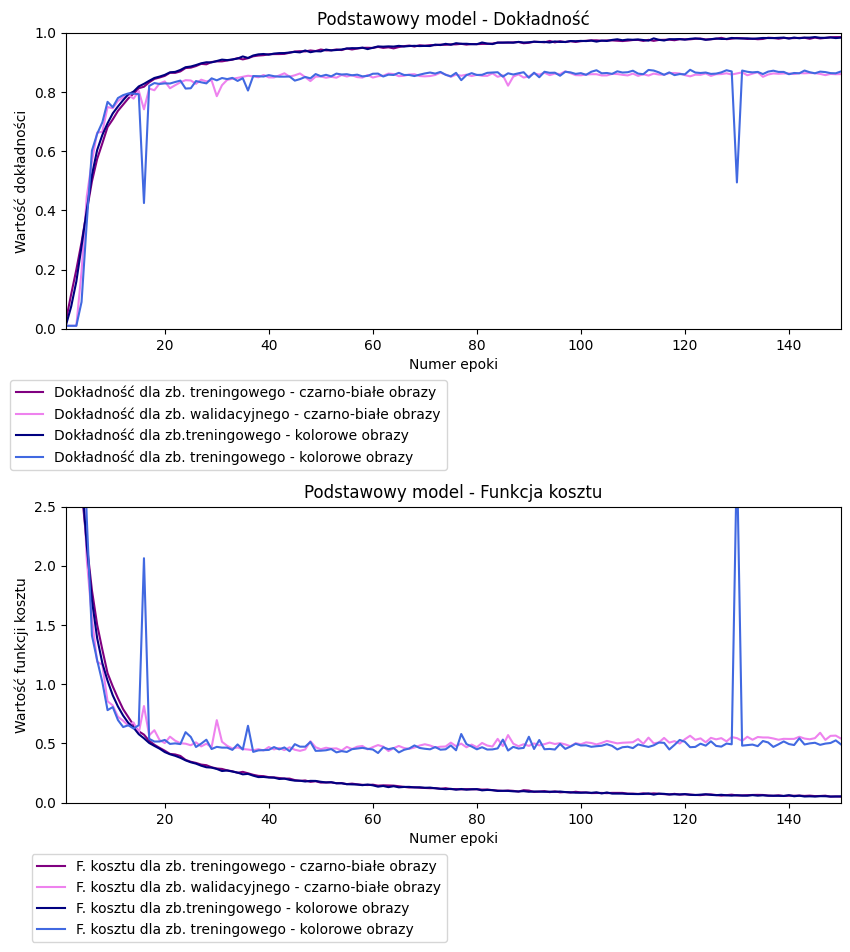

In [ ]:
plot_params(res_bw, res_c, 'Podstawowy model')

In [ ]:
def get_augmentation_model(labels_len, channels_num=3):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.02),
        tf.keras.layers.RandomZoom([-0.15, 0]),
    ])

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100, 100, channels_num)))
    model.add(data_augmentation)
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    add_conv_block(model, 20, activation=tf.keras.activations.relu, dropout=0.1)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 40, activation=tf.keras.activations.relu, dropout=0.2)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 80, activation=tf.keras.activations.relu, dropout=0.3)
    model.add(tf.keras.layers.BatchNormalization())
    add_conv_block(model, 160, activation=tf.keras.activations.relu, dropout=0.4)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(labels_len, activation=tf.keras.activations.softmax))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
res_c_2 = run_model(get_augmentation_model(d_col.labels_len), d_col)
res_bw_2 = run_model(get_augmentation_model(d_bw.labels_len, 1), d_bw)

Epoch 1/150
152/152 [==============================] - 12s 65ms/step - loss: 5.4570 - accuracy: 0.0096 - val_loss: 4.6936 - val_accuracy: 0.0103
Epoch 2/150
152/152 [==============================] - 9s 61ms/step - loss: 5.3518 - accuracy: 0.0078 - val_loss: 4.8045 - val_accuracy: 0.0103
Epoch 3/150
152/152 [==============================] - 10s 63ms/step - loss: 4.4381 - accuracy: 0.0607 - val_loss: 6.2819 - val_accuracy: 0.0103
Epoch 4/150
152/152 [==============================] - 10s 63ms/step - loss: 3.6168 - accuracy: 0.1524 - val_loss: 3.5730 - val_accuracy: 0.1309
Epoch 5/150
152/152 [==============================] - 10s 63ms/step - loss: 2.9292 - accuracy: 0.2571 - val_loss: 2.6420 - val_accuracy: 0.3500
Epoch 6/150
152/152 [==============================] - 9s 61ms/step - loss: 2.3179 - accuracy: 0.3818 - val_loss: 2.0613 - val_accuracy: 0.4624
Epoch 7/150
152/152 [==============================] - 9s 62ms/step - loss: 1.8657 - accuracy: 0.4813 - val_loss: 1.5705 - val_accur

In [ ]:
dump_res(res_bw_2, res_c_2)

0.8716495037078857 [0.010309278033673763, 0.010309278033673763, 0.030412370339035988, 0.15773196518421173, 0.12010309100151062, 0.09072165191173553, 0.039175257086753845, 0.5288659930229187, 0.06546391546726227, 0.5206185579299927, 0.3010309338569641, 0.5268041491508484, 0.048969071358442307, 0.02319587580859661, 0.5139175057411194, 0.5134020447731018, 0.019072165712714195, 0.7701030969619751, 0.7675257921218872, 0.7912371158599854, 0.8139175176620483, 0.758247435092926, 0.08556701242923737, 0.6603092551231384, 0.5829896926879883, 0.0871134027838707, 0.789175271987915, 0.8195876479148865, 0.7896907329559326, 0.8139175176620483, 0.8041236996650696, 0.8273195624351501, 0.14123710989952087, 0.8247422575950623, 0.6659793853759766, 0.7896907329559326, 0.8417525887489319, 0.8257731795310974, 0.789175271987915, 0.8494845628738403, 0.8376288414001465, 0.8376288414001465, 0.8484535813331604, 0.8092783689498901, 0.820103108882904, 0.6386597752571106, 0.8355669975280762, 0.8226804137229919, 0.696

In [ ]:
#0.8716495037078857 [0.010309278033673763, 0.010309278033673763, 0.030412370339035988, 0.15773196518421173, 0.12010309100151062, 0.09072165191173553, 0.039175257086753845, 0.5288659930229187, 0.06546391546726227, 0.5206185579299927, 0.3010309338569641, 0.5268041491508484, 0.048969071358442307, 0.02319587580859661, 0.5139175057411194, 0.5134020447731018, 0.019072165712714195, 0.7701030969619751, 0.7675257921218872, 0.7912371158599854, 0.8139175176620483, 0.758247435092926, 0.08556701242923737, 0.6603092551231384, 0.5829896926879883, 0.0871134027838707, 0.789175271987915, 0.8195876479148865, 0.7896907329559326, 0.8139175176620483, 0.8041236996650696, 0.8273195624351501, 0.14123710989952087, 0.8247422575950623, 0.6659793853759766, 0.7896907329559326, 0.8417525887489319, 0.8257731795310974, 0.789175271987915, 0.8494845628738403, 0.8376288414001465, 0.8376288414001465, 0.8484535813331604, 0.8092783689498901, 0.820103108882904, 0.6386597752571106, 0.8355669975280762, 0.8226804137229919, 0.6969072222709656, 0.047422681003808975, 0.8340206146240234, 0.8149484395980835, 0.6757732033729553, 0.8159793615341187, 0.8128865957260132, 0.8494845628738403, 0.8489691019058228, 0.5510309338569641, 0.8546391725540161, 0.6170102953910828, 0.8376288414001465, 0.8608247637748718, 0.8195876479148865, 0.853608250617981, 0.8293814659118652, 0.8567010164260864, 0.861855685710907, 0.8288660049438477, 0.853608250617981, 0.699999988079071, 0.660824716091156, 0.2974226772785187, 0.8448453545570374, 0.857216477394104, 0.7422680258750916, 0.8443298935890198, 0.7613402009010315, 0.8608247637748718, 0.7402061820030212, 0.8541237115859985, 0.857216477394104, 0.8551546335220337, 0.7577319741249084, 0.8608247637748718, 0.8412371277809143, 0.8474226593971252, 0.8051546216011047, 0.8530927896499634, 0.8438144326210022, 0.8469071984291077, 0.8092783689498901, 0.7319587469100952, 0.8474226593971252, 0.8577319383621216, 0.5056701302528381, 0.8546391725540161, 0.8567010164260864, 0.8695876002311707, 0.8329896926879883, 0.8664948344230652, 0.8159793615341187, 0.8505154848098755, 0.8649484515190125, 0.8716495037078857, 0.8608247637748718, 0.86546391248703, 0.86546391248703, 0.8592783212661743, 0.8597938418388367, 0.8561855554580688, 0.853608250617981, 0.8587628602981567, 0.6324742436408997, 0.8623711466789246, 0.8273195624351501, 0.8670102953910828, 0.8577319383621216, 0.8448453545570374, 0.8680412173271179, 0.8695876002311707, 0.8644329905509949, 0.8597938418388367, 0.8190721869468689, 0.8613402247428894, 0.508247435092926, 0.8489691019058228, 0.8304123878479004, 0.8500000238418579, 0.8603093028068542, 0.8592783212661743, 0.8608247637748718, 0.8628866076469421, 0.8680412173271179, 0.8515464067459106, 0.8597938418388367, 0.842783510684967, 0.7845360636711121, 0.8371133804321289, 0.8567010164260864, 0.8170102834701538, 0.8695876002311707, 0.7969072461128235, 0.8716495037078857, 0.8283505439758301, 0.8525773286819458, 0.8639175295829773, 0.8639175295829773, 0.7798969149589539, 0.7546391487121582, 0.8659793734550476]
#0.9557731747627258 [0.009999999776482582, 0.012474226765334606, 0.048556700348854065, 0.11453608423471451, 0.1702061891555786, 0.2677319645881653, 0.3545360863208771, 0.45845359563827515, 0.5246391892433167, 0.5864948630332947, 0.6205154657363892, 0.6625773310661316, 0.6868041157722473, 0.70742267370224, 0.7192783355712891, 0.7398968935012817, 0.7597938179969788, 0.7677319645881653, 0.7818556427955627, 0.7980412244796753, 0.7917525768280029, 0.8059793710708618, 0.807835042476654, 0.8196907043457031, 0.824123740196228, 0.8293814659118652, 0.8360824584960938, 0.841340184211731, 0.8539175391197205, 0.8532989621162415, 0.8556700944900513, 0.8602061867713928, 0.8608247637748718, 0.8611339926719666, 0.8697938323020935, 0.8714432716369629, 0.8745360970497131, 0.8751546144485474, 0.8750515580177307, 0.8822680115699768, 0.8797938227653503, 0.8830927610397339, 0.8821649551391602, 0.885360836982727, 0.8947422504425049, 0.8911340236663818, 0.8922680616378784, 0.89577317237854, 0.8989690542221069, 0.8976288437843323, 0.9043298959732056, 0.8979381322860718, 0.9026803970336914, 0.9036082625389099, 0.9088659882545471, 0.9084535837173462, 0.9071133732795715, 0.9076288938522339, 0.9057732224464417, 0.9100000262260437, 0.9113401770591736, 0.9146391749382019, 0.9115464091300964, 0.9141237139701843, 0.9098969101905823, 0.9186598062515259, 0.9183505177497864, 0.9132989645004272, 0.9175257682800293, 0.9214432835578918, 0.9223711490631104, 0.9193814396858215, 0.9220618605613708, 0.9200000166893005, 0.9246391654014587, 0.9246391654014587, 0.9226804375648499, 0.9291752576828003, 0.9251546263694763, 0.922474205493927, 0.9243298768997192, 0.9246391654014587, 0.92711341381073, 0.9334020614624023, 0.9289690852165222, 0.9324742555618286, 0.931134045124054, 0.9306185841560364, 0.9308247566223145, 0.9319587349891663, 0.9324742555618286, 0.9321649670600891, 0.9397938251495361, 0.9361855387687683, 0.9355670213699341, 0.934742271900177, 0.9340206384658813, 0.9358763098716736, 0.9349484443664551, 0.9391752481460571, 0.934742271900177, 0.9364948272705078, 0.9345360994338989, 0.9384536147117615, 0.9361855387687683, 0.937525749206543, 0.9396907091140747, 0.9386597871780396, 0.9411340355873108, 0.9384536147117615, 0.9376288652420044, 0.9432989954948425, 0.942371129989624, 0.9451546669006348, 0.9461855888366699, 0.9401031136512756, 0.9439175128936768, 0.9428865909576416, 0.9461855888366699, 0.945773184299469, 0.942989706993103, 0.9410309195518494, 0.9437113404273987, 0.9445360898971558, 0.9452577233314514, 0.9424742460250854, 0.942783534526825, 0.9501031041145325, 0.9478350281715393, 0.9467010498046875, 0.9508247375488281, 0.9475257992744446, 0.9448453783988953, 0.950412392616272, 0.9480412602424622, 0.9508247375488281, 0.947010338306427, 0.9472165107727051, 0.9490721821784973, 0.9493814706802368, 0.949793815612793, 0.9524742364883423, 0.9514433145523071, 0.9514433145523071, 0.9542267918586731, 0.9501031041145325, 0.95061856508255, 0.9519587755203247, 0.9516494870185852, 0.9557731747627258]
#0.4189159870147705 [4.6966986656188965, 4.818427562713623, 6.994803428649902, 3.343884229660034, 3.6540510654449463, 3.9171407222747803, 8.424105644226074, 1.7265121936798096, 4.959567070007324, 1.605246901512146, 2.562068462371826, 1.5463109016418457, 8.584616661071777, 13.554241180419922, 1.6015241146087646, 1.5831661224365234, 29.550382614135742, 0.7018982768058777, 0.7549462914466858, 0.6943321824073792, 0.5842608213424683, 0.753990888595581, 6.960127830505371, 1.0453342199325562, 1.3539817333221436, 7.196205139160156, 0.654417872428894, 0.5517637133598328, 0.6322097182273865, 0.5338332056999207, 0.6030541658401489, 0.539781391620636, 5.771298408508301, 0.5167335271835327, 1.07930588722229, 0.63429856300354, 0.47220945358276367, 0.5201188921928406, 0.6691932678222656, 0.45867493748664856, 0.5034251809120178, 0.46959444880485535, 0.4635997414588928, 0.605362594127655, 0.5514349341392517, 1.2026687860488892, 0.48988693952560425, 0.5242486596107483, 1.0037102699279785, 12.050675392150879, 0.48605674505233765, 0.5432024002075195, 1.0799139738082886, 0.5469340085983276, 0.5745709538459778, 0.47022250294685364, 0.4533505141735077, 1.6083945035934448, 0.4414011240005493, 1.250307321548462, 0.49910029768943787, 0.4285881519317627, 0.5562389492988586, 0.4363403916358948, 0.5639374852180481, 0.44878342747688293, 0.43178945779800415, 0.5574372410774231, 0.4393666386604309, 0.9854617118835449, 1.0971709489822388, 4.055949687957764, 0.47222599387168884, 0.45065170526504517, 0.8474541306495667, 0.48289358615875244, 0.7434921264648438, 0.4335637390613556, 0.8073416352272034, 0.46381232142448425, 0.4432067275047302, 0.4336082935333252, 0.8194384574890137, 0.43382757902145386, 0.5150223970413208, 0.48713618516921997, 0.6683444380760193, 0.4629172086715698, 0.4749140441417694, 0.48014676570892334, 0.6350750923156738, 0.9654965996742249, 0.48214420676231384, 0.44167637825012207, 2.0287699699401855, 0.468332976102829, 0.44440701603889465, 0.4189159870147705, 0.5749174952507019, 0.4234900176525116, 0.5714585781097412, 0.45384201407432556, 0.45374688506126404, 0.4266749322414398, 0.4577101171016693, 0.4472128450870514, 0.4396241009235382, 0.4370196461677551, 0.428445965051651, 0.4661552906036377, 0.4736955463886261, 0.45135927200317383, 1.2996833324432373, 0.44889044761657715, 0.5289366841316223, 0.42967313528060913, 0.4406941831111908, 0.5068431496620178, 0.42253565788269043, 0.42759132385253906, 0.4459647834300995, 0.4645760655403137, 0.6237053871154785, 0.4492003321647644, 1.9833791255950928, 0.4928237199783325, 0.565379798412323, 0.47100380063056946, 0.4562797248363495, 0.4570606052875519, 0.44637590646743774, 0.4526839852333069, 0.4503417909145355, 0.4670793414115906, 0.4570712149143219, 0.5234559774398804, 0.7333285808563232, 0.5432421565055847, 0.49473780393600464, 0.584466278553009, 0.4313388764858246, 0.6784117221832275, 0.4410610795021057, 0.5377892851829529, 0.49581533670425415, 0.48067009449005127, 0.44097188115119934, 0.7520076036453247, 0.8983045816421509, 0.4322642982006073]
#0.12085386365652084 [5.467507839202881, 5.320902347564697, 4.5100789070129395, 3.7832295894622803, 3.29923677444458, 2.8224411010742188, 2.4061594009399414, 1.9805850982666016, 1.6866607666015625, 1.448161005973816, 1.2950743436813354, 1.1537084579467773, 1.0537508726119995, 0.9520238041877747, 0.9156816601753235, 0.8383611440658569, 0.7794308662414551, 0.7384321093559265, 0.7078583240509033, 0.6455880999565125, 0.6366081833839417, 0.6022154092788696, 0.5866068601608276, 0.5469236373901367, 0.5295806527137756, 0.5185503959655762, 0.49414199590682983, 0.475893497467041, 0.4486932158470154, 0.4433214068412781, 0.4374869167804718, 0.41487792134284973, 0.410991907119751, 0.40252912044525146, 0.3918454647064209, 0.3822990655899048, 0.3756265342235565, 0.37263327836990356, 0.36085245013237, 0.343601793050766, 0.3508354127407074, 0.33916330337524414, 0.3330684304237366, 0.3232721984386444, 0.3083558678627014, 0.313799649477005, 0.31131094694137573, 0.3034411668777466, 0.29381924867630005, 0.3000614047050476, 0.27286675572395325, 0.28825807571411133, 0.27308017015457153, 0.2714264988899231, 0.2601810395717621, 0.2672039568424225, 0.26218655705451965, 0.2614125907421112, 0.2633231282234192, 0.2611369490623474, 0.2517848312854767, 0.24632883071899414, 0.24506808817386627, 0.23615415394306183, 0.2470715492963791, 0.23602889478206635, 0.22658514976501465, 0.2375996708869934, 0.23290668427944183, 0.2208094447851181, 0.2190304398536682, 0.217681422829628, 0.21390590071678162, 0.2216188609600067, 0.20934610068798065, 0.21436284482479095, 0.21168270707130432, 0.20326289534568787, 0.21106815338134766, 0.20945003628730774, 0.20323897898197174, 0.20342382788658142, 0.19944265484809875, 0.18990281224250793, 0.19324785470962524, 0.1924380660057068, 0.19166253507137299, 0.19356580078601837, 0.18474650382995605, 0.1904175877571106, 0.18558739125728607, 0.18149276077747345, 0.17448627948760986, 0.1764356791973114, 0.17776228487491608, 0.17706415057182312, 0.17646992206573486, 0.17541475594043732, 0.1739039421081543, 0.1735009253025055, 0.18126846849918365, 0.17488324642181396, 0.17627735435962677, 0.16812321543693542, 0.16913102567195892, 0.17183271050453186, 0.16813385486602783, 0.16459707915782928, 0.16334687173366547, 0.16545850038528442, 0.16446684300899506, 0.15929147601127625, 0.15714776515960693, 0.15153253078460693, 0.15285351872444153, 0.1589728742837906, 0.1525585800409317, 0.15985292196273804, 0.1496129333972931, 0.15050694346427917, 0.15055319666862488, 0.1537441462278366, 0.15409086644649506, 0.1516515016555786, 0.1474083960056305, 0.1545104831457138, 0.15118631720542908, 0.13633552193641663, 0.14269359409809113, 0.1429309993982315, 0.13760390877723694, 0.13717259466648102, 0.14715057611465454, 0.1353597193956375, 0.14666201174259186, 0.134869784116745, 0.13863235712051392, 0.14237062633037567, 0.13666655123233795, 0.13804082572460175, 0.13262337446212769, 0.13045771420001984, 0.13617058098316193, 0.13145315647125244, 0.13002640008926392, 0.13400352001190186, 0.13833706080913544, 0.12990985810756683, 0.13070231676101685, 0.12085386365652084]
#0.873711347579956 [0.010309278033673763, 0.010309278033673763, 0.010309278033673763, 0.13092783093452454, 0.3499999940395355, 0.4623711407184601, 0.6030927896499634, 0.6360824704170227, 0.6582474112510681, 0.7371134161949158, 0.08556701242923737, 0.31134021282196045, 0.40463918447494507, 0.7979381680488586, 0.7149484753608704, 0.7458763122558594, 0.5737113356590271, 0.011855670250952244, 0.8046391606330872, 0.7603092789649963, 0.7422680258750916, 0.7484536170959473, 0.8329896926879883, 0.06855670362710953, 0.8304123878479004, 0.8448453545570374, 0.8376288414001465, 0.33814433217048645, 0.36701029539108276, 0.1453608274459839, 0.8051546216011047, 0.8438144326210022, 0.2520618438720703, 0.6360824704170227, 0.29845359921455383, 0.05309278517961502, 0.8432989716529846, 0.8530927896499634, 0.8005154728889465, 0.8360824584960938, 0.861855685710907, 0.8500000238418579, 0.8381443023681641, 0.7731958627700806, 0.746391773223877, 0.8422680497169495, 0.0737113431096077, 0.853608250617981, 0.8546391725540161, 0.8005154728889465, 0.8649484515190125, 0.857216477394104, 0.8541237115859985, 0.0469072163105011, 0.8030927777290344, 0.1582474261522293, 0.8613402247428894, 0.861855685710907, 0.43144330382347107, 0.8603093028068542, 0.8402062058448792, 0.09896907210350037, 0.8639175295829773, 0.2943299114704132, 0.8582473993301392, 0.8484535813331604, 0.8417525887489319, 0.8546391725540161, 0.7159793972969055, 0.8298969268798828, 0.8634020686149597, 0.8329896926879883, 0.6458762884140015, 0.842783510684967, 0.8639175295829773, 0.8582473993301392, 0.8561855554580688, 0.6984536051750183, 0.20927834510803223, 0.8587628602981567, 0.8597938418388367, 0.07835051417350769, 0.3458762764930725, 0.8649484515190125, 0.03453608229756355, 0.11443299055099487, 0.8587628602981567, 0.06649484485387802, 0.86546391248703, 0.86546391248703, 0.050515465438365936, 0.7185567021369934, 0.03659793734550476, 0.09896907210350037, 0.8623711466789246, 0.16237112879753113, 0.2943299114704132, 0.8335051536560059, 0.4551546275615692, 0.07164948433637619, 0.8278350234031677, 0.2030927836894989, 0.8592783212661743, 0.861855685710907, 0.15000000596046448, 0.8639175295829773, 0.8644329905509949, 0.8556700944900513, 0.8546391725540161, 0.8587628602981567, 0.8628866076469421, 0.8561855554580688, 0.8634020686149597, 0.4865979254245758, 0.8546391725540161, 0.8675257563591003, 0.873711347579956, 0.8639175295829773, 0.8680412173271179, 0.8597938418388367, 0.8608247637748718, 0.8546391725540161, 0.49639174342155457, 0.09793814271688461, 0.8613402247428894, 0.7515463829040527, 0.048969071358442307, 0.8582473993301392, 0.8721649646759033, 0.4907216429710388, 0.8577319383621216, 0.39381444454193115, 0.8365979194641113, 0.10309278219938278, 0.857216477394104, 0.8685566782951355, 0.7902061939239502, 0.8659793734550476, 0.11134020984172821, 0.8711340427398682, 0.8685566782951355, 0.8582473993301392, 0.8644329905509949, 0.1340206116437912, 0.8644329905509949, 0.10618557035923004, 0.834536075592041, 0.8644329905509949, 0.8685566782951355, 0.03865979239344597]
#0.9606185555458069 [0.00958762876689434, 0.007835051976144314, 0.06072165071964264, 0.1523711383342743, 0.25711339712142944, 0.3817525804042816, 0.4813401997089386, 0.5608247518539429, 0.619484543800354, 0.6652577519416809, 0.7058762907981873, 0.7315464019775391, 0.7546391487121582, 0.7703092694282532, 0.7871134281158447, 0.8009278178215027, 0.8041236996650696, 0.8136082291603088, 0.823298990726471, 0.8315463662147522, 0.8386598229408264, 0.8426803946495056, 0.8480412364006042, 0.8508247137069702, 0.861443281173706, 0.861443281173706, 0.8692783713340759, 0.8662886619567871, 0.8755670189857483, 0.8746391534805298, 0.8840206265449524, 0.8732989430427551, 0.888144314289093, 0.8837113380432129, 0.8848453760147095, 0.8936082720756531, 0.8902061581611633, 0.8965979218482971, 0.8960824608802795, 0.896391749382019, 0.8986597657203674, 0.9032989740371704, 0.9067010283470154, 0.9030928015708923, 0.9064948558807373, 0.9043298959732056, 0.9062886834144592, 0.90804123878479, 0.9115464091300964, 0.9129896759986877, 0.9117525815963745, 0.9146391749382019, 0.9152577519416809, 0.9139175415039062, 0.9143298864364624, 0.9176288843154907, 0.9185566902160645, 0.9187628626823425, 0.9232989549636841, 0.9219587445259094, 0.9221649765968323, 0.9234020709991455, 0.9246391654014587, 0.9261855483055115, 0.925876259803772, 0.9280412197113037, 0.9219587445259094, 0.9291752576828003, 0.9289690852165222, 0.9280412197113037, 0.9319587349891663, 0.9259793758392334, 0.9328866004943848, 0.930515468120575, 0.9331958889961243, 0.9339175224304199, 0.9338144063949585, 0.9335051774978638, 0.9346391558647156, 0.9393814206123352, 0.9376288652420044, 0.9342268109321594, 0.9388659596443176, 0.9355670213699341, 0.9377319812774658, 0.9371134042739868, 0.937525749206543, 0.9405154585838318, 0.9390721917152405, 0.9426804184913635, 0.9412370920181274, 0.942164957523346, 0.9420618414878845, 0.9399999976158142, 0.9422680139541626, 0.942783534526825, 0.9467010498046875, 0.9462886452674866, 0.9428865909576416, 0.9456701278686523, 0.9442268013954163, 0.9458763003349304, 0.9459793567657471, 0.9509278535842896, 0.9467010498046875, 0.9467010498046875, 0.9460824728012085, 0.9493814706802368, 0.9478350281715393, 0.9482474327087402, 0.9511340260505676, 0.9503092765808105, 0.9490721821784973, 0.9487628936767578, 0.9522680640220642, 0.9507216215133667, 0.9485567212104797, 0.9474226832389832, 0.9542267918586731, 0.9519587755203247, 0.9530927538871765, 0.9505154490470886, 0.9522680640220642, 0.9544329643249512, 0.9542267918586731, 0.9521649479866028, 0.9542267918586731, 0.9542267918586731, 0.951237142086029, 0.9530927538871765, 0.9552577137947083, 0.9555670022964478, 0.9539175033569336, 0.9550515413284302, 0.9536082744598389, 0.9496906995773315, 0.9536082744598389, 0.9556701183319092, 0.9556701183319092, 0.9606185555458069, 0.9557731747627258, 0.9585567116737366, 0.9571133852005005, 0.9559794068336487, 0.9563917517662048, 0.9575257897377014, 0.9601030945777893, 0.9551546573638916, 0.9598969221115112, 0.9605154395103455]
#0.39684489369392395 [4.693568229675293, 4.804503917694092, 6.281937122344971, 3.5729634761810303, 2.6420390605926514, 2.061311721801758, 1.5704938173294067, 1.3131729364395142, 1.1559813022613525, 0.9077231287956238, 6.459737300872803, 2.550089120864868, 2.2313992977142334, 0.6187123656272888, 0.9469563364982605, 0.7938645482063293, 1.4152412414550781, 27.148326873779297, 0.5752251148223877, 0.7297691702842712, 0.8025538921356201, 0.7459322214126587, 0.4977627098560333, 11.100090980529785, 0.4854128062725067, 0.4581373631954193, 0.487769216299057, 3.0063090324401855, 2.6646695137023926, 5.56551456451416, 0.5838229060173035, 0.4772147536277771, 4.469971179962158, 1.234129548072815, 3.516359806060791, 11.208778381347656, 0.445570170879364, 0.413203626871109, 0.567179799079895, 0.449155330657959, 0.4264330565929413, 0.42154788970947266, 0.4758753180503845, 0.7093798518180847, 0.8048920631408691, 0.46515974402427673, 10.508606910705566, 0.40860432386398315, 0.43953073024749756, 0.639087438583374, 0.39684489369392395, 0.4400525689125061, 0.4112459719181061, 13.73134708404541, 0.615164041519165, 6.989259243011475, 0.4042724072933197, 0.41317445039749146, 2.7453207969665527, 0.40679535269737244, 0.46799519658088684, 9.095558166503906, 0.41102147102355957, 4.060276985168457, 0.4201946556568146, 0.4361530840396881, 0.4764408767223358, 0.41016826033592224, 0.9095171093940735, 0.5202080011367798, 0.39972102642059326, 0.5070446729660034, 1.2978802919387817, 0.4783787131309509, 0.40723004937171936, 0.4201819598674774, 0.4452359080314636, 1.0195252895355225, 5.86698055267334, 0.40845274925231934, 0.40050509572029114, 11.711698532104492, 3.3150784969329834, 0.41801342368125916, 18.99959945678711, 8.201767921447754, 0.42015591263771057, 10.602437973022461, 0.41326549649238586, 0.40738391876220703, 13.300919532775879, 0.9438568353652954, 20.125402450561523, 9.46072006225586, 0.40030983090400696, 6.821042537689209, 4.6652750968933105, 0.49028488993644714, 2.5581412315368652, 11.579204559326172, 0.5176079273223877, 6.105595588684082, 0.4136350750923157, 0.4055308401584625, 7.765305042266846, 0.4113987982273102, 0.4136977791786194, 0.44621798396110535, 0.45404231548309326, 0.46192672848701477, 0.4390319883823395, 0.4652050733566284, 0.4039500653743744, 2.4729928970336914, 0.4484626352787018, 0.4178822338581085, 0.4220282733440399, 0.4483788013458252, 0.4184970259666443, 0.45043912529945374, 0.43008697032928467, 0.4678972065448761, 2.409665107727051, 10.467342376708984, 0.43625786900520325, 0.8167828917503357, 17.089570999145508, 0.4500039219856262, 0.4237058758735657, 2.309926986694336, 0.4481975734233856, 3.5341074466705322, 0.5146527886390686, 9.834477424621582, 0.42577457427978516, 0.4185429811477661, 0.7107162475585938, 0.4182550609111786, 9.446327209472656, 0.4284062385559082, 0.42119958996772766, 0.43448734283447266, 0.4427589476108551, 8.208701133728027, 0.4285685420036316, 10.516839027404785, 0.5461366772651672, 0.42035385966300964, 0.4464915990829468, 20.813148498535156]
#0.11005732417106628 [5.4569501876831055, 5.3517632484436035, 4.438093185424805, 3.6168439388275146, 2.9292407035827637, 2.3178837299346924, 1.8657399415969849, 1.5396521091461182, 1.3095632791519165, 1.1281553506851196, 0.973111093044281, 0.881259560585022, 0.816914975643158, 0.7511908411979675, 0.687605082988739, 0.640234649181366, 0.606810450553894, 0.5867918133735657, 0.56074059009552, 0.5295402407646179, 0.5013368129730225, 0.48374974727630615, 0.4615134596824646, 0.43652912974357605, 0.42587578296661377, 0.41153883934020996, 0.4015876054763794, 0.39211970567703247, 0.3772309422492981, 0.367154598236084, 0.35534337162971497, 0.36849668622016907, 0.34026268124580383, 0.3377058804035187, 0.32737040519714355, 0.3140067458152771, 0.3155238926410675, 0.30310237407684326, 0.3007872998714447, 0.29937198758125305, 0.2858527898788452, 0.2787819504737854, 0.26961538195610046, 0.270613431930542, 0.2707659602165222, 0.26735609769821167, 0.2643972337245941, 0.26589739322662354, 0.25083863735198975, 0.2484746277332306, 0.24502363801002502, 0.2406153529882431, 0.23770274221897125, 0.23442207276821136, 0.23689775168895721, 0.23784849047660828, 0.2270963340997696, 0.229294553399086, 0.21714894473552704, 0.2185395359992981, 0.21356651186943054, 0.21465958654880524, 0.20872299373149872, 0.20861662924289703, 0.20272941887378693, 0.2049684375524521, 0.20872893929481506, 0.1979062855243683, 0.19855619966983795, 0.19763413071632385, 0.18663376569747925, 0.19612939655780792, 0.18589094281196594, 0.19023174047470093, 0.1868991255760193, 0.17928995192050934, 0.18173933029174805, 0.17963694036006927, 0.17830698192119598, 0.17329750955104828, 0.17224399745464325, 0.1790236532688141, 0.17142407596111298, 0.1733594834804535, 0.17189361155033112, 0.17433249950408936, 0.16873732209205627, 0.17108631134033203, 0.165691077709198, 0.1573360413312912, 0.15910206735134125, 0.16152526438236237, 0.15915094316005707, 0.1641412228345871, 0.15864711999893188, 0.15664295852184296, 0.15040011703968048, 0.1467762291431427, 0.14544036984443665, 0.1542029231786728, 0.14847610890865326, 0.14830712974071503, 0.14477798342704773, 0.1363164335489273, 0.14841005206108093, 0.14668048918247223, 0.14160889387130737, 0.13798727095127106, 0.14238891005516052, 0.14078937470912933, 0.1363060176372528, 0.1366332620382309, 0.13886681199073792, 0.14089438319206238, 0.13188721239566803, 0.13206903636455536, 0.1359167844057083, 0.14137931168079376, 0.12668544054031372, 0.1305037885904312, 0.13080863654613495, 0.1401648074388504, 0.129618301987648, 0.12401892989873886, 0.12586607038974762, 0.12932147085666656, 0.12725929915905, 0.12816931307315826, 0.12658005952835083, 0.12193091213703156, 0.12438569962978363, 0.11953161656856537, 0.12285483628511429, 0.12422383576631546, 0.12663157284259796, 0.13098494708538055, 0.12316843867301941, 0.12274416536092758, 0.1196189746260643, 0.11605513095855713, 0.11875887215137482, 0.1133015975356102, 0.11610636115074158, 0.1208372488617897, 0.11479701101779938, 0.11604052782058716, 0.11339068412780762, 0.11934974044561386, 0.11005732417106628, 0.11121872812509537]

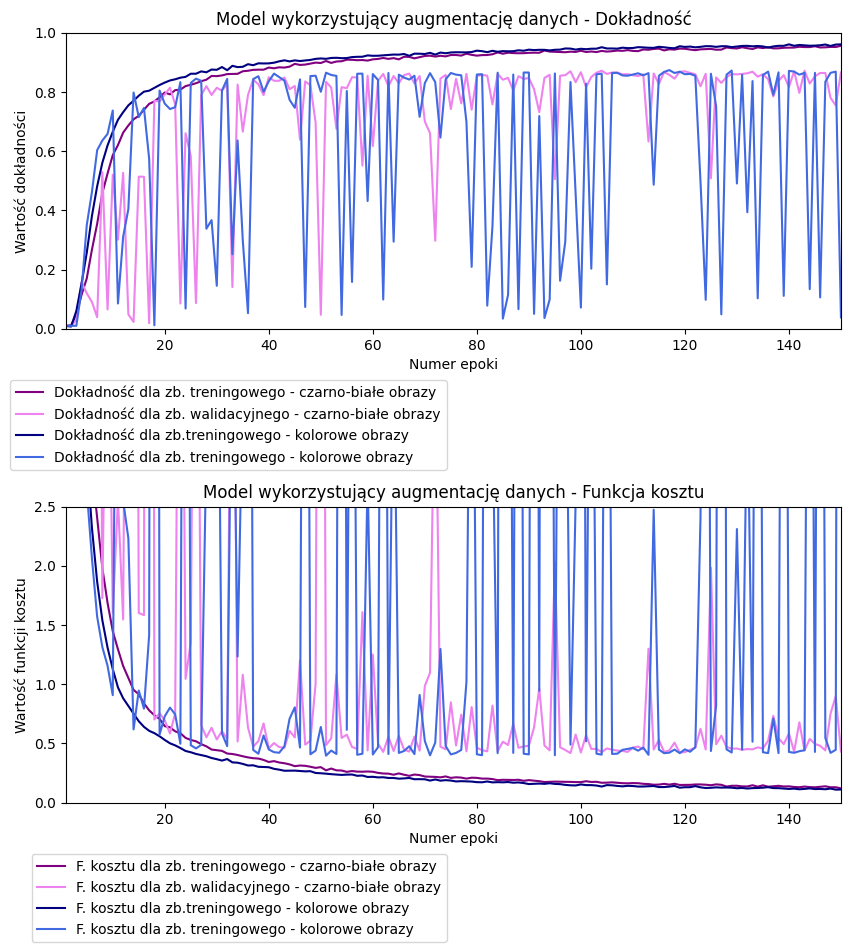

In [ ]:
plot_params(res_bw_2, res_c_2, 'Model wykorzystujący augmentację danych')

In [21]:
def get_transfer_based_model(labels_len, base_model):
    inputs = tf.keras.Input(shape=(100, 100, 3))
    base_model.trainable = False
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(labels_len)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [25]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(100, 100, 3),
                                               include_top=False,
                                               weights='imagenet')
res_c_3 = run_model(get_transfer_based_model(d_col.labels_len, base_model), d_col)
res_bw_3 = run_model(get_transfer_based_model(d_bw_3.labels_len, base_model), d_bw_3)

Epoch 1/150
152/152 [==============================] - 16s 77ms/step - loss: 0.2370 - accuracy: 0.0099 - val_loss: 0.0796 - val_accuracy: 0.0093
Epoch 2/150
152/152 [==============================] - 11s 70ms/step - loss: 0.0727 - accuracy: 0.0155 - val_loss: 0.0627 - val_accuracy: 0.0258
Epoch 3/150
152/152 [==============================] - 11s 70ms/step - loss: 0.0629 - accuracy: 0.0336 - val_loss: 0.0582 - val_accuracy: 0.0644
Epoch 4/150
152/152 [==============================] - 10s 63ms/step - loss: 0.0590 - accuracy: 0.0573 - val_loss: 0.0555 - val_accuracy: 0.1149
Epoch 5/150
152/152 [==============================] - 10s 67ms/step - loss: 0.0561 - accuracy: 0.0871 - val_loss: 0.0532 - val_accuracy: 0.1629
Epoch 6/150
152/152 [==============================] - 11s 72ms/step - loss: 0.0538 - accuracy: 0.1184 - val_loss: 0.0511 - val_accuracy: 0.1959
Epoch 7/150
152/152 [==============================] - 10s 64ms/step - loss: 0.0514 - accuracy: 0.1485 - val_loss: 0.0492 - val_ac

In [26]:
dump_res(res_bw_3, res_c_3)

0.6891752481460571 [0.00463917525485158, 0.012886597774922848, 0.035567011684179306, 0.06958762556314468, 0.09432989358901978, 0.14123710989952087, 0.17371134459972382, 0.20463918149471283, 0.23556700348854065, 0.27113401889801025, 0.29587629437446594, 0.3097938001155853, 0.32474225759506226, 0.33814433217048645, 0.3567010164260864, 0.3793814480304718, 0.3902061879634857, 0.39845362305641174, 0.41443300247192383, 0.41855669021606445, 0.43453606963157654, 0.44793814420700073, 0.4618556797504425, 0.464948445558548, 0.4804123640060425, 0.4932989776134491, 0.5041236877441406, 0.5092783570289612, 0.5170103311538696, 0.5278350710868835, 0.5335051417350769, 0.5371134281158447, 0.5489690899848938, 0.5510309338569641, 0.5546391606330872, 0.561855673789978, 0.5608247518539429, 0.5721649527549744, 0.5726804137229919, 0.5793814659118652, 0.5814433097839355, 0.5788660049438477, 0.5922680497169495, 0.5938144326210022, 0.5963917374610901, 0.5938144326210022, 0.5989691019058228, 0.6015464067459106, 0.

In [ ]:
#0.6891752481460571 [0.00463917525485158, 0.012886597774922848, 0.035567011684179306, 0.06958762556314468, 0.09432989358901978, 0.14123710989952087, 0.17371134459972382, 0.20463918149471283, 0.23556700348854065, 0.27113401889801025, 0.29587629437446594, 0.3097938001155853, 0.32474225759506226, 0.33814433217048645, 0.3567010164260864, 0.3793814480304718, 0.3902061879634857, 0.39845362305641174, 0.41443300247192383, 0.41855669021606445, 0.43453606963157654, 0.44793814420700073, 0.4618556797504425, 0.464948445558548, 0.4804123640060425, 0.4932989776134491, 0.5041236877441406, 0.5092783570289612, 0.5170103311538696, 0.5278350710868835, 0.5335051417350769, 0.5371134281158447, 0.5489690899848938, 0.5510309338569641, 0.5546391606330872, 0.561855673789978, 0.5608247518539429, 0.5721649527549744, 0.5726804137229919, 0.5793814659118652, 0.5814433097839355, 0.5788660049438477, 0.5922680497169495, 0.5938144326210022, 0.5963917374610901, 0.5938144326210022, 0.5989691019058228, 0.6015464067459106, 0.6015464067459106, 0.6123711466789246, 0.6041237115859985, 0.6139175295829773, 0.6087628602981567, 0.6190721392631531, 0.6216495037078857, 0.6190721392631531, 0.6221649646759033, 0.6231958866119385, 0.6231958866119385, 0.6283504962921143, 0.6257731914520264, 0.6278350353240967, 0.626288652420044, 0.6268041133880615, 0.629896879196167, 0.629896879196167, 0.6340206265449524, 0.6350515484809875, 0.6365979313850403, 0.6422680616378784, 0.6417526006698608, 0.6360824704170227, 0.6402061581611633, 0.6412371397018433, 0.6443299055099487, 0.6443299055099487, 0.6432989835739136, 0.6443299055099487, 0.6448453664779663, 0.6469072103500366, 0.6530928015708923, 0.6458762884140015, 0.6458762884140015, 0.6515464186668396, 0.6453608274459839, 0.6567010283470154, 0.6536082625389099, 0.6556701064109802, 0.6567010283470154, 0.6520618796348572, 0.6551546454429626, 0.657216489315033, 0.6587628722190857, 0.6556701064109802, 0.6582474112510681, 0.657216489315033, 0.6567010283470154, 0.6623711585998535, 0.6577319502830505, 0.6634020805358887, 0.6603092551231384, 0.6613401770591736, 0.6649484634399414, 0.6623711585998535, 0.6623711585998535, 0.6644330024719238, 0.6701030731201172, 0.6649484634399414, 0.6675257682800293, 0.6701030731201172, 0.6701030731201172, 0.6701030731201172, 0.6716494560241699, 0.6685566902160645, 0.6721649765968323, 0.669072151184082, 0.669072151184082, 0.6778350472450256, 0.6721649765968323, 0.6819587349891663, 0.6731958985328674, 0.6716494560241699, 0.6788659691810608, 0.6747422814369202, 0.679896891117096, 0.6778350472450256, 0.6768041253089905, 0.6762886643409729, 0.6804123520851135, 0.6804123520851135, 0.6819587349891663, 0.6804123520851135, 0.6871134042739868, 0.6814432740211487, 0.6788659691810608, 0.6829897165298462, 0.6840206384658813, 0.6855670213699341, 0.6804123520851135, 0.6865979433059692, 0.6850515604019165, 0.6814432740211487, 0.6804123520851135, 0.6814432740211487, 0.6845360994338989, 0.6835051774978638, 0.6845360994338989, 0.6891752481460571, 0.6855670213699341, 0.6814432740211487]
#0.7841237187385559 [0.009072165004909039, 0.013092783279716969, 0.022680412977933884, 0.03752577304840088, 0.05556701123714447, 0.07742267847061157, 0.09721649438142776, 0.12597937881946564, 0.1570103019475937, 0.17536082863807678, 0.20731958746910095, 0.22938144207000732, 0.26505154371261597, 0.2858762741088867, 0.303608238697052, 0.3198969066143036, 0.334536075592041, 0.3601031005382538, 0.3744329810142517, 0.3913401961326599, 0.4001030921936035, 0.4160824716091156, 0.42701029777526855, 0.45092782378196716, 0.46000000834465027, 0.4694845378398895, 0.47649484872817993, 0.4895876348018646, 0.4996907114982605, 0.5113402009010315, 0.515876293182373, 0.5302062034606934, 0.5342267751693726, 0.5486598014831543, 0.5564948320388794, 0.5580412149429321, 0.5707216262817383, 0.5790721774101257, 0.5830928087234497, 0.5881443023681641, 0.5969071984291077, 0.5964948534965515, 0.6057732105255127, 0.6086598038673401, 0.6151546239852905, 0.6165979504585266, 0.620103120803833, 0.6282474398612976, 0.6331958770751953, 0.6373195648193359, 0.6364948749542236, 0.6417526006698608, 0.6481443047523499, 0.6520618796348572, 0.6523711085319519, 0.6554639339447021, 0.6526803970336914, 0.6589690446853638, 0.6611340045928955, 0.6684536337852478, 0.6712371110916138, 0.6716494560241699, 0.6712371110916138, 0.673711359500885, 0.6763917803764343, 0.6781443357467651, 0.6819587349891663, 0.6810309290885925, 0.6872165203094482, 0.6864948272705078, 0.6830927729606628, 0.6930927634239197, 0.6978350281715393, 0.692164957523346, 0.7039175033569336, 0.6955670118331909, 0.7050515413284302, 0.6992783546447754, 0.7050515413284302, 0.7071133852005005, 0.7076288461685181, 0.7084535956382751, 0.7072165012359619, 0.7090721726417542, 0.7154639363288879, 0.7157732248306274, 0.7245360612869263, 0.71969074010849, 0.7222680449485779, 0.7277319431304932, 0.7243298888206482, 0.7287628650665283, 0.7246391773223877, 0.7262886762619019, 0.7270103096961975, 0.7358762621879578, 0.7292783260345459, 0.7325773239135742, 0.7330927848815918, 0.735567033290863, 0.7328866124153137, 0.7351546287536621, 0.7373195886611938, 0.7373195886611938, 0.7415463924407959, 0.7441236972808838, 0.7443298697471619, 0.746391773223877, 0.7464948296546936, 0.7436082363128662, 0.7494845390319824, 0.7479381561279297, 0.754020631313324, 0.7513402104377747, 0.7514433264732361, 0.7550515532493591, 0.7518556714057922, 0.7545360922813416, 0.749381422996521, 0.7598969340324402, 0.7569072246551514, 0.7593814730644226, 0.7588659524917603, 0.7618556618690491, 0.7629896998405457, 0.765257716178894, 0.7630927562713623, 0.7668040990829468, 0.7635051608085632, 0.7624742388725281, 0.7704123854637146, 0.7729896903038025, 0.7677319645881653, 0.7703092694282532, 0.7691752314567566, 0.7734020352363586, 0.7731958627700806, 0.7693814635276794, 0.7754639387130737, 0.7720618844032288, 0.7757731676101685, 0.7737113237380981, 0.7778350710868835, 0.7785567045211792, 0.7709278464317322, 0.7808247208595276, 0.7811340093612671, 0.776701033115387, 0.7808247208595276, 0.7841237187385559]
#0.020987307652831078 [0.0969679057598114, 0.06737803667783737, 0.06083819642663002, 0.057876456528902054, 0.05580158159136772, 0.05403558164834976, 0.05241229757666588, 0.05089116841554642, 0.049430396407842636, 0.0480719655752182, 0.04680325463414192, 0.045640066266059875, 0.04452171176671982, 0.04348297789692879, 0.042513273656368256, 0.041595540940761566, 0.040756210684776306, 0.03992544114589691, 0.039180029183626175, 0.03846938535571098, 0.03777670860290527, 0.0371142253279686, 0.036480534821748734, 0.0358988419175148, 0.03534907102584839, 0.03479423001408577, 0.03430714085698128, 0.03380861505866051, 0.03331863507628441, 0.03288882598280907, 0.032444439828395844, 0.032062679529190063, 0.03164677321910858, 0.03128707781434059, 0.030943594872951508, 0.03059738501906395, 0.030259879305958748, 0.029952460899949074, 0.02966306172311306, 0.02937452122569084, 0.02908519096672535, 0.0288658756762743, 0.028587697073817253, 0.02837122604250908, 0.02811477705836296, 0.027926374226808548, 0.02770182676613331, 0.027530666440725327, 0.02730010449886322, 0.02711481787264347, 0.026950320228934288, 0.026766037568449974, 0.026617348194122314, 0.02642953395843506, 0.026265239343047142, 0.02613368257880211, 0.0260065495967865, 0.025843987241387367, 0.025745924562215805, 0.02560793049633503, 0.025487050414085388, 0.025358671322464943, 0.025220738723874092, 0.02515047788619995, 0.02503630891442299, 0.024928828701376915, 0.02481505088508129, 0.024739764630794525, 0.02459055930376053, 0.024532034993171692, 0.02441950887441635, 0.02433359995484352, 0.024251064285635948, 0.024163447320461273, 0.024084683507680893, 0.024003932252526283, 0.023920640349388123, 0.023868149146437645, 0.023774048313498497, 0.02374178171157837, 0.02363930270075798, 0.023585543036460876, 0.023495066910982132, 0.023423822596669197, 0.023363258689641953, 0.023317188024520874, 0.023229623213410378, 0.023188620805740356, 0.02314172126352787, 0.023074280470609665, 0.023039458319544792, 0.022928958758711815, 0.022883949801325798, 0.022830940783023834, 0.022812776267528534, 0.022800706326961517, 0.022718951106071472, 0.022647187113761902, 0.022590799257159233, 0.0225664135068655, 0.022541210055351257, 0.02246820740401745, 0.02244621329009533, 0.02237076312303543, 0.022354157641530037, 0.022277025505900383, 0.022216377779841423, 0.022193724289536476, 0.02220124751329422, 0.02213853783905506, 0.022087713703513145, 0.022016355767846107, 0.022025303915143013, 0.021988580003380775, 0.021924417465925217, 0.0219014473259449, 0.02188659831881523, 0.021858174353837967, 0.021817252039909363, 0.021756088361144066, 0.021763255819678307, 0.02172480709850788, 0.021665433421730995, 0.021656429395079613, 0.021623387932777405, 0.021584700793027878, 0.021558158099651337, 0.02153238095343113, 0.021494591608643532, 0.02148258499801159, 0.021445028483867645, 0.021414754912257195, 0.021358709782361984, 0.021354323253035545, 0.02132694236934185, 0.021299846470355988, 0.021280230954289436, 0.021208608523011208, 0.02122141793370247, 0.021199196577072144, 0.021193016320466995, 0.021147018298506737, 0.021114112809300423, 0.021118944510817528, 0.021095657721161842, 0.021027227863669395, 0.021080806851387024, 0.021020662039518356, 0.02102177031338215, 0.020987307652831078]
#0.016676049679517746 [0.3020136058330536, 0.08355026692152023, 0.06689466536045074, 0.06160236895084381, 0.05878139287233353, 0.05657726153731346, 0.05479525402188301, 0.0529513880610466, 0.05130302906036377, 0.0497463122010231, 0.04841374605894089, 0.04718971252441406, 0.045728880912065506, 0.04453762248158455, 0.043558891862630844, 0.042540550231933594, 0.04157106205821037, 0.04061320796608925, 0.039829954504966736, 0.03903236985206604, 0.03831206262111664, 0.03757159411907196, 0.036866966634988785, 0.03610338643193245, 0.03545486554503441, 0.03484448045492172, 0.03426043689250946, 0.033732540905475616, 0.03320138156414032, 0.03263348340988159, 0.03216757997870445, 0.03173336014151573, 0.03126165643334389, 0.030829597264528275, 0.030376287177205086, 0.029948191717267036, 0.029599539935588837, 0.029179221019148827, 0.02885972149670124, 0.028471024706959724, 0.028221970424056053, 0.027874352410435677, 0.02752968668937683, 0.027250299230217934, 0.02702314779162407, 0.02672921121120453, 0.026471683755517006, 0.026206860318779945, 0.025934554636478424, 0.025698082521557808, 0.02550564333796501, 0.025316206738352776, 0.02508729323744774, 0.024870198220014572, 0.024691788479685783, 0.024497030302882195, 0.024332422763109207, 0.02415376529097557, 0.023974230512976646, 0.023721924051642418, 0.023591164499521255, 0.02346624992787838, 0.023345334455370903, 0.023156728595495224, 0.022983616217970848, 0.022922268137335777, 0.02273435890674591, 0.022639725357294083, 0.022473052144050598, 0.022283047437667847, 0.02225995808839798, 0.022046172991394997, 0.02187887206673622, 0.02184898592531681, 0.021686401218175888, 0.02160506322979927, 0.021532421931624413, 0.021440530195832253, 0.021281806752085686, 0.02115369401872158, 0.021091019734740257, 0.02100885845720768, 0.020882558077573776, 0.020843228325247765, 0.02069925330579281, 0.020580550655722618, 0.020459022372961044, 0.020431838929653168, 0.020313967019319534, 0.02021690271794796, 0.020139742642641068, 0.02010956034064293, 0.020004168152809143, 0.019890040159225464, 0.019807005301117897, 0.019744742661714554, 0.01962927170097828, 0.019556501880288124, 0.01955057494342327, 0.01945183426141739, 0.019401485100388527, 0.01931515522301197, 0.019256185740232468, 0.019199639558792114, 0.019026534631848335, 0.018969345837831497, 0.01894761063158512, 0.018835896626114845, 0.018851278349757195, 0.01876683533191681, 0.01867416501045227, 0.018655510619282722, 0.018539097160100937, 0.018472077324986458, 0.01842934638261795, 0.018336931243538857, 0.018346766009926796, 0.018238568678498268, 0.01825747638940811, 0.01818588189780712, 0.018137328326702118, 0.01805834472179413, 0.017918644472956657, 0.017905330285429955, 0.017895406112074852, 0.017784005030989647, 0.01779181696474552, 0.017698628827929497, 0.01769472286105156, 0.0176785197108984, 0.017477087676525116, 0.017511509358882904, 0.017504839226603508, 0.01744169555604458, 0.01735559292137623, 0.01731369085609913, 0.017275596037507057, 0.017161132767796516, 0.017195791006088257, 0.017146743834018707, 0.017077520489692688, 0.016999399289488792, 0.01704064942896366, 0.01696091517806053, 0.016927961260080338, 0.016860172152519226, 0.01685130037367344, 0.01682920753955841, 0.016747819259762764, 0.016676049679517746]
#0.6778350472450256 [0.00927835050970316, 0.025773195549845695, 0.06443298608064651, 0.11494845151901245, 0.1628866046667099, 0.19587628543376923, 0.23969072103500366, 0.26649484038352966, 0.3041236996650696, 0.32886597514152527, 0.3530927896499634, 0.3711340129375458, 0.39587628841400146, 0.40515464544296265, 0.42938143014907837, 0.4376288652420044, 0.4489690661430359, 0.46288660168647766, 0.47216495871543884, 0.47835052013397217, 0.4804123640060425, 0.49690720438957214, 0.49896907806396484, 0.5077319741249084, 0.5170103311538696, 0.5103092789649963, 0.527319610118866, 0.5324742197990417, 0.5432989597320557, 0.5324742197990417, 0.5510309338569641, 0.5474227070808411, 0.5567010045051575, 0.5603092908859253, 0.5639175176620483, 0.570103108882904, 0.5706185698509216, 0.5742267966270447, 0.5768041014671326, 0.5793814659118652, 0.5855669975280762, 0.5881443023681641, 0.5907216668128967, 0.5953608155250549, 0.5958762764930725, 0.5984535813331604, 0.6041237115859985, 0.6015464067459106, 0.607216477394104, 0.6061855554580688, 0.6087628602981567, 0.6175257563591003, 0.6108247637748718, 0.6134020686149597, 0.6149484515190125, 0.61546391248703, 0.6180412173271179, 0.6185566782951355, 0.6206185817718506, 0.6226804256439209, 0.6304123997688293, 0.6288659572601318, 0.6242268085479736, 0.6340206265449524, 0.6293814182281494, 0.6293814182281494, 0.629896879196167, 0.6304123997688293, 0.6329897046089172, 0.6340206265449524, 0.6350515484809875, 0.6371133923530579, 0.6371133923530579, 0.638144314289093, 0.6360824704170227, 0.6422680616378784, 0.6396906971931458, 0.6371133923530579, 0.642783522605896, 0.6422680616378784, 0.6412371397018433, 0.6443299055099487, 0.6510308980941772, 0.6489690542221069, 0.642783522605896, 0.6499999761581421, 0.6479381322860718, 0.6479381322860718, 0.6469072103500366, 0.6505154371261597, 0.646391749382019, 0.6510308980941772, 0.6505154371261597, 0.6510308980941772, 0.6525773406028748, 0.6582474112510681, 0.6510308980941772, 0.6556701064109802, 0.6489690542221069, 0.6561855673789978, 0.6556701064109802, 0.6577319502830505, 0.657216489315033, 0.6577319502830505, 0.6587628722190857, 0.6618556976318359, 0.6597937941551208, 0.6556701064109802, 0.6603092551231384, 0.6597937941551208, 0.6634020805358887, 0.6592783331871033, 0.6603092551231384, 0.6639175415039062, 0.6675257682800293, 0.6659793853759766, 0.6634020805358887, 0.6639175415039062, 0.6639175415039062, 0.6659793853759766, 0.6675257682800293, 0.6680412292480469, 0.6726804375648499, 0.6731958985328674, 0.6664948463439941, 0.6680412292480469, 0.669072151184082, 0.6716494560241699, 0.669072151184082, 0.6670103073120117, 0.6726804375648499, 0.6634020805358887, 0.6701030731201172, 0.6695876121520996, 0.6695876121520996, 0.6706185340881348, 0.6701030731201172, 0.6731958985328674, 0.6695876121520996, 0.6752577424049377, 0.6726804375648499, 0.6721649765968323, 0.6664948463439941, 0.6706185340881348, 0.6721649765968323, 0.6721649765968323, 0.673711359500885, 0.6706185340881348, 0.6778350472450256, 0.6768041253089905]
#0.823298990726471 [0.009896907024085522, 0.015463917516171932, 0.033608246594667435, 0.05731958895921707, 0.0871134027838707, 0.11835051327943802, 0.14845360815525055, 0.17391753196716309, 0.20896907150745392, 0.24020618200302124, 0.26731958985328674, 0.2942267954349518, 0.32010307908058167, 0.34628865122795105, 0.3639175295829773, 0.392164945602417, 0.40804123878479004, 0.42711341381073, 0.4339175224304199, 0.4527834951877594, 0.47505155205726624, 0.48876288533210754, 0.5002061724662781, 0.5053608417510986, 0.5123711228370667, 0.5292783379554749, 0.534329891204834, 0.5494845509529114, 0.557216465473175, 0.5689690709114075, 0.5660824775695801, 0.5788660049438477, 0.5881443023681641, 0.5924742221832275, 0.5972164869308472, 0.6093814373016357, 0.6127834916114807, 0.6241236925125122, 0.6249484419822693, 0.6285567283630371, 0.6338144540786743, 0.6414433121681213, 0.6454639434814453, 0.6484535932540894, 0.653195858001709, 0.6642268300056458, 0.6587628722190857, 0.6675257682800293, 0.6716494560241699, 0.6770102977752686, 0.6752577424049377, 0.6814432740211487, 0.6837113499641418, 0.6879381537437439, 0.6943299174308777, 0.6948453783988953, 0.6949484348297119, 0.6977319717407227, 0.7045360803604126, 0.7048453688621521, 0.7050515413284302, 0.7094845175743103, 0.7105154395103455, 0.7121649384498596, 0.7186598181724548, 0.7181443572044373, 0.7248453497886658, 0.7265979647636414, 0.7278350591659546, 0.7281443476676941, 0.7314432859420776, 0.7315464019775391, 0.7323711514472961, 0.7339175343513489, 0.7371134161949158, 0.7406185269355774, 0.7447422742843628, 0.7473195791244507, 0.7449484467506409, 0.7489690780639648, 0.7460824847221375, 0.7482474446296692, 0.7555670142173767, 0.753608226776123, 0.7537113428115845, 0.7613402009010315, 0.7526804208755493, 0.7593814730644226, 0.7641237378120422, 0.765257716178894, 0.7642267942428589, 0.7689690589904785, 0.7679381370544434, 0.7741237282752991, 0.7747422456741333, 0.7777319550514221, 0.7753608226776123, 0.7765979170799255, 0.7728865742683411, 0.7764948606491089, 0.7771133780479431, 0.7820618748664856, 0.7807216644287109, 0.783711314201355, 0.7869071960449219, 0.7869071960449219, 0.7857732176780701, 0.787938117980957, 0.7907216548919678, 0.7842267751693726, 0.791958749294281, 0.7868041396141052, 0.7880412340164185, 0.7916494607925415, 0.7990721464157104, 0.795360803604126, 0.7924742102622986, 0.800000011920929, 0.7958762645721436, 0.7986598014831543, 0.8024742007255554, 0.8012371063232422, 0.7994845509529114, 0.8020618557929993, 0.8010309338569641, 0.800206184387207, 0.8046391606330872, 0.8020618557929993, 0.807835042476654, 0.8081443309783936, 0.8090721368789673, 0.815257728099823, 0.812474250793457, 0.8123711347579956, 0.8160824775695801, 0.8148453831672668, 0.8174226880073547, 0.8167010545730591, 0.8175257444381714, 0.8172165155410767, 0.8190721869468689, 0.8190721869468689, 0.8176288604736328, 0.8225772976875305, 0.8207216262817383, 0.8218556642532349, 0.823298990726471, 0.819278359413147, 0.823298990726471, 0.8225772976875305]
#0.020556509494781494 [0.07956519722938538, 0.06270300596952438, 0.05821460485458374, 0.05550616607069969, 0.05322809889912605, 0.05114782974123955, 0.04924379289150238, 0.04748560115695, 0.04588136076927185, 0.044426001608371735, 0.043132901191711426, 0.041891712695360184, 0.04075757786631584, 0.03972462937235832, 0.038827694952487946, 0.037916820496320724, 0.0371389240026474, 0.03635835647583008, 0.03567914292216301, 0.0350261926651001, 0.034397635608911514, 0.033828817307949066, 0.033296387642621994, 0.03279051557183266, 0.03228314220905304, 0.031816188246011734, 0.03136314079165459, 0.030966371297836304, 0.030556296929717064, 0.030195463448762894, 0.029814081266522408, 0.029507441446185112, 0.029190009459853172, 0.028907345607876778, 0.028572892770171165, 0.02828456275165081, 0.028074961155653, 0.027816500514745712, 0.027594400569796562, 0.027357490733265877, 0.02715202048420906, 0.026941539719700813, 0.026719538494944572, 0.026584699749946594, 0.026364192366600037, 0.026195239275693893, 0.026012558490037918, 0.025874901562929153, 0.025715479627251625, 0.02558690309524536, 0.02541041187942028, 0.025305336341261864, 0.02517150528728962, 0.0250678900629282, 0.02496775984764099, 0.024787254631519318, 0.024704644456505775, 0.024621764197945595, 0.02446972392499447, 0.024402206763625145, 0.024308035150170326, 0.02417576313018799, 0.024114469066262245, 0.02399645932018757, 0.023921871557831764, 0.02384653314948082, 0.023749053478240967, 0.023719197139143944, 0.02361213229596615, 0.023539196699857712, 0.023425810039043427, 0.023410527035593987, 0.0233196709305048, 0.023240938782691956, 0.02322436310350895, 0.02309790626168251, 0.023079166188836098, 0.023028789088129997, 0.022922897711396217, 0.022894222289323807, 0.022809525951743126, 0.022732770070433617, 0.02267901971936226, 0.022600606083869934, 0.02259804680943489, 0.022513598203659058, 0.022475892677903175, 0.022459344938397408, 0.02238093502819538, 0.022323738783597946, 0.022328000515699387, 0.022240083664655685, 0.022224044427275658, 0.022155504673719406, 0.022065481171011925, 0.022056974470615387, 0.022011535242199898, 0.021960493177175522, 0.022010954096913338, 0.02193092182278633, 0.021864287555217743, 0.021823668852448463, 0.021792998537421227, 0.021726015955209732, 0.021720437332987785, 0.02170688845217228, 0.021648332476615906, 0.021640753373503685, 0.021574553102254868, 0.021543962880969048, 0.021554671227931976, 0.021496448665857315, 0.021449673920869827, 0.02146090567111969, 0.021348590031266212, 0.021379638463258743, 0.021345017477869987, 0.021259458735585213, 0.021252723410725594, 0.021236971020698547, 0.0212230421602726, 0.02116604894399643, 0.02118818648159504, 0.021105347201228142, 0.021111568436026573, 0.021093178540468216, 0.021053889766335487, 0.021041136234998703, 0.021033601835370064, 0.020991705358028412, 0.020964156836271286, 0.020978011190891266, 0.020891817286610603, 0.020861225202679634, 0.0208791084587574, 0.02082669548690319, 0.020871948450803757, 0.02082774043083191, 0.020835459232330322, 0.020741602405905724, 0.020758820697665215, 0.020768627524375916, 0.020698973909020424, 0.02069779671728611, 0.02070152573287487, 0.020641857758164406, 0.02062993124127388, 0.020608223974704742, 0.02055973932147026, 0.020556509494781494]
#0.01442172471433878 [0.23698845505714417, 0.07266654074192047, 0.06286685168743134, 0.059003379195928574, 0.05614051967859268, 0.05377139896154404, 0.051445212215185165, 0.049567811191082, 0.047596849501132965, 0.045974113047122955, 0.04425859451293945, 0.04302741214632988, 0.041594382375478745, 0.04053473845124245, 0.03938024491071701, 0.03830310329794884, 0.03741680830717087, 0.03643200546503067, 0.035618074238300323, 0.03484232351183891, 0.03400813788175583, 0.033296264708042145, 0.03265624865889549, 0.032133109867572784, 0.03147439286112785, 0.03088468499481678, 0.030381720513105392, 0.029847607016563416, 0.0293680839240551, 0.02887639030814171, 0.028500158339738846, 0.02802088111639023, 0.027709385380148888, 0.02729371003806591, 0.026912977918982506, 0.026532180607318878, 0.026137620210647583, 0.02588949166238308, 0.025547528639435768, 0.025340978056192398, 0.025000499561429024, 0.024714501574635506, 0.024454185739159584, 0.024198759347200394, 0.02393370121717453, 0.023711739107966423, 0.02358444407582283, 0.02330668829381466, 0.02305222488939762, 0.022801831364631653, 0.022683152928948402, 0.022467145696282387, 0.022275296971201897, 0.022043682634830475, 0.021885186433792114, 0.021715139970183372, 0.021583110094070435, 0.021425025537610054, 0.021229753270745277, 0.021075723692774773, 0.02100497856736183, 0.020876478403806686, 0.020683269947767258, 0.02054644003510475, 0.02039618417620659, 0.020278265699744225, 0.020184962078928947, 0.020014118403196335, 0.019850213080644608, 0.01979374885559082, 0.019727645441889763, 0.01955963671207428, 0.0194549560546875, 0.019335683435201645, 0.01927967742085457, 0.019103655591607094, 0.018970100209116936, 0.018912535160779953, 0.018811622634530067, 0.018688375130295753, 0.018665295094251633, 0.018567927181720734, 0.01849839650094509, 0.018334319815039635, 0.018307683989405632, 0.018133623525500298, 0.018140573054552078, 0.017988255247473717, 0.017940586432814598, 0.017839573323726654, 0.017671506851911545, 0.0176837295293808, 0.017563732340931892, 0.017505070194602013, 0.01740448549389839, 0.017316848039627075, 0.017235005274415016, 0.017197152599692345, 0.017236171290278435, 0.017105842009186745, 0.016986936330795288, 0.016868162900209427, 0.016850220039486885, 0.016730131581425667, 0.016656544059515, 0.01662902906537056, 0.01663341000676155, 0.016542185097932816, 0.016429532319307327, 0.016473062336444855, 0.016293447464704514, 0.016233323141932487, 0.01621452160179615, 0.016231771558523178, 0.01609499566257, 0.01608208566904068, 0.016014857217669487, 0.015912659466266632, 0.01588931865990162, 0.015832912176847458, 0.015756472945213318, 0.015744557604193687, 0.015655340626835823, 0.015643775463104248, 0.015657765790820122, 0.01554315909743309, 0.015423297882080078, 0.015500834211707115, 0.0153618473559618, 0.015314311720430851, 0.015221315436065197, 0.015157061628997326, 0.015181408263742924, 0.015119918622076511, 0.015050140209496021, 0.01503690704703331, 0.014921415597200394, 0.014949698001146317, 0.01484408974647522, 0.01484697125852108, 0.01482986006885767, 0.014701679348945618, 0.014705237932503223, 0.014641325920820236, 0.01465737447142601, 0.01454934198409319, 0.014503659680485725, 0.014460275880992413, 0.014469820074737072, 0.01442172471433878]

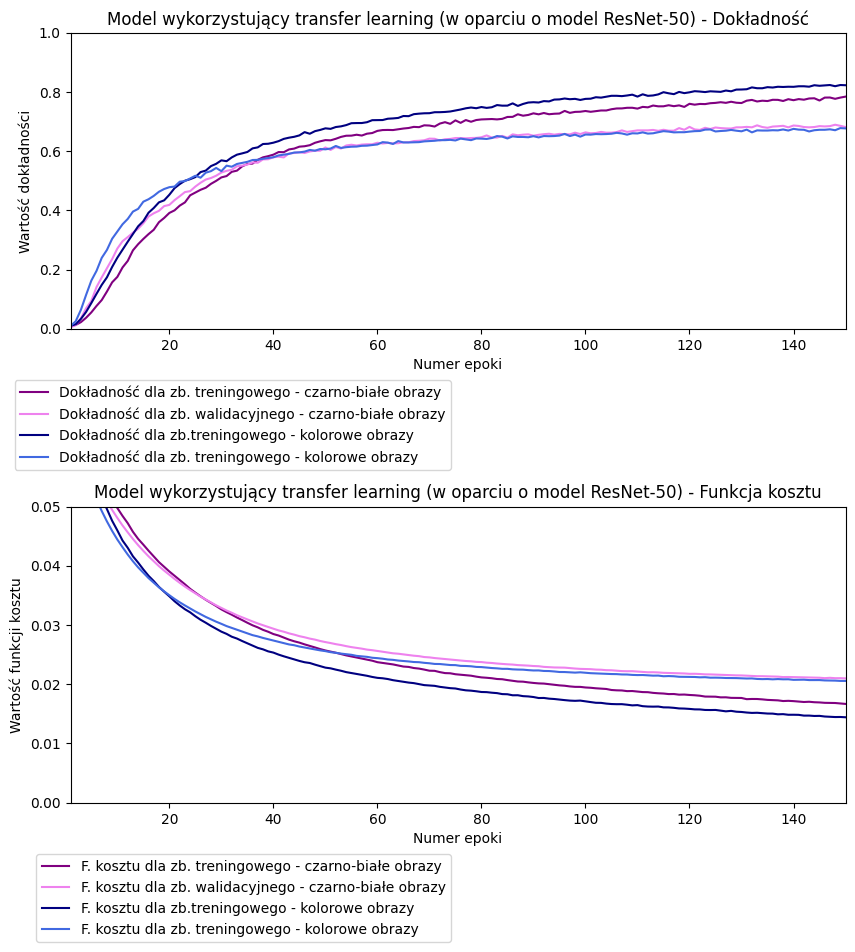

In [31]:
plot_params(res_bw_3, res_c_3, 'Model wykorzystujący transfer learning (w oparciu o model ResNet-50)')

In [32]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

# todo

83683744/83683744 [==============================] - 3s 0us/step
